# Itay Sharfer 208005587 Shahar Nissim 315903526
Kaggle Account : https://www.kaggle.com/itaysharfer
<br>Kaggle Account : https://www.kaggle.com/shaharnissim


<div style="font-size:30px;"> TLDR:</div>

<div style="font-size:20px;">
Our objective in this project is to predict whether a passenger on the Titanic survived.
<br> To accomplish this, we analyzed how different features in the dataset influence a passenger's survival chance.
<br> We utilized various graphs and plots to visualize the data and identify correlations between the features and survival rates.
<br> Following the data visualization, we explored new hyperparameters to enhance our model's accuracy.
<br> We experimented with different sub-groups of features, training our models on these sub-groups while considering the best train-validation ratio.
<br>   After identifying the optimal sub-group, we submitted our best accuracy score to the competition.
</div>

<div style="font-size:20px;"></div>

<div style="font-size:30px;"> Data Analysis:</div>

<div style="font-size:20px;"> Importing the necessary libraries and defining graph attributes:</div>

In [105]:
# import numpy, matplotlib, etc.
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn imports
import sklearn
from sklearn import metrics
from sklearn import datasets
from sklearn import pipeline
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import neural_network

# define plt settings
sns.set_theme()
plt.rcParams["font.size"] = 20
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["legend.fontsize"] = 20
plt.rcParams["legend.markerscale"] = 1.5
plt.rcParams["figure.figsize"] = (9, 5)
plt.rcParams["legend.title_fontsize"] = 20

# plotly imports
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

#ignore future warnings
import warnings
warnings.filterwarnings('ignore')

<div style="font-size:20px;"> Functions that will be used later:</div>

In [106]:

 #Calculates a given model score on a given train and validation sets.   
def calc_model_score(model, X_train, t_train, X_val, t_val):
    model.fit(X_train, t_train)
    y_train = model.predict(X_train)
    y_val = model.predict(X_val)
    train_score = model.score(X_train, t_train)
    val_score = model.score(X_val, t_val)
    return train_score, val_score

#Generates 4 graphs showing loss and scores on train and validation sets based on split ratio
def print_graphs(graph_points, title):
    fig = make_subplots(rows=2, cols=2, subplot_titles=[f"{title}: {k}" for k in graph_points.keys()])
    for i, (k, v) in enumerate(graph_points.items()):
        values = list(v.values())
        keys = list(v.keys())
        best_value = max(values) if 'R2' in k else min(values)
        best_index = np.argmax(values) if 'R2' in k else np.argmin(values)
        color = 'red' if 'train' in k else 'blue'
        row = i // 2 + 1
        col = i % 2 + 1
        scatter = go.Scatter(x=keys, y=values, mode='markers+lines', marker=dict(color=color), name=f"{k}, best value: x={keys[best_index]}, y={best_value}")
        fig.add_trace(scatter, row=row, col=col)

    fig.update_layout(title_text=title, width=1600, height=800)
    fig.show()
    
# plot the score by split and the loss by split
def plot_score_and_loss_by_split(X, t):
    graph_points = {
                    'train_loss_func':{},
                    'val_loss_func': {},
                    'train_Score': {},
                    'val_Score': {}
                    }
    lr = LogisticRegression()
    sgd = pipeline.make_pipeline(preprocessing.StandardScaler(), linear_model.SGDClassifier(loss='log_loss', alpha=0, learning_rate='constant', eta0=0.01))
    mlp = neural_network.MLPClassifier(activation='logistic',solver='sgd', alpha=0, max_iter=10000)
    models = [lr, sgd, mlp]
    models_strings = ['Logistic Regression', 'SGD Classifier', 'MLP']
    for model, str in zip(models, models_strings):
        for size in range(10, 100, 10):
            X_train, X_val, t_train, t_val = model_selection.train_test_split(
                X.values, t.values, test_size=size/100, random_state=42)
            curr_model = model.fit(X_train, t_train)
            y_train = curr_model.predict(X_train)
            y_val = curr_model.predict(X_val)
            graph_points['train_loss_func'][size/100] = metrics.log_loss(t_train, y_train)
            graph_points['val_loss_func'][size/100] = metrics.log_loss(t_val, y_val)
            graph_points['train_Score'][size/100] = curr_model.score(X_train, t_train)
            graph_points['val_Score'][size/100] = curr_model.score(X_val, t_val)
        print_graphs(graph_points, str)
        
# calculates scores of all models based on their ideal splits  
def calcScore(splitLR, splitSGD, splitMLP, X, t):
    lr = LogisticRegression()
    sgd = pipeline.make_pipeline(preprocessing.StandardScaler(), linear_model.SGDClassifier(loss='log_loss', alpha=0, learning_rate='constant', eta0=0.01))
    mlp = neural_network.MLPClassifier(activation='logistic',solver='sgd', alpha=0, max_iter=10000)
    models = [lr, sgd, mlp]
    models_strings = ['Logistic Regression', 'SGD Classifier', 'MLP']
    splits = [splitLR, splitSGD,splitMLP]
    results = {
        "Model": [],
        "Train Score": [],
        "Validation Score": []
    }
    for model, split, name in zip(models, splits, models_strings):
        X_train, X_val, t_train, t_val = model_selection.train_test_split(X, t, test_size=split, random_state=42)
        train_score, val_score = calc_model_score(model, X_train, t_train, X_val, t_val)
        results["Model"].append(name)
        results["Train Score"].append(train_score)
        results["Validation Score"].append(val_score)
    result_df = pd.DataFrame(results)
    display(result_df)
        

<div style="font-size:20px;"> We will look at the different features on the dataset and try to determine how they affect the survival chance of a person</div>

<div style="font-size:20px;"> Loading the data:</div>

In [107]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [108]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


<div style="font-size:20px;"> Data Cleaning:</div>

<div style="font-size:20px;"> Let's see the percentage of null values for each feature:</div>

In [109]:
total_null_values = train_data.isnull().sum()
null_percentage = total_null_values / len(train_data) * 100
print(null_percentage)

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64


<br><div style="font-size:20px;"> We can see that the Cabin column has 77% of its data missing. Therefore we won't be using it for our model.
<br> Since the name, ticket-number and passengerId values of each member are irrelevent to the survival chance of a passanger, we won't be using them for our model.
We will fill the missing values in the 'Age' column by calculating the median for each respective dataframe.
</div>

In [110]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [111]:
test_data['Fare'].fillna(test_data['Fare'].median(), inplace = True)

<div style="font-size:20px;">
 Let's see how many of the female and male passengers survived:
</div>

In [112]:
surv_rate_by_sex = train_data.dropna(subset=['Sex', 'Survived'])
survival_percentage = surv_rate_by_sex.groupby('Sex')['Survived'].mean() * 100
survival_percentage_df = survival_percentage.reset_index()
survival_percentage_df.columns = ['Sex', 'Survival Percentage']
fig = px.bar(survival_percentage_df, x='Sex', y='Survival Percentage', 
             title='Survival Rate of Men and Women on the Titanic', 
             labels={'Sex': 'Gender', 'Survival Percentage': 'Survival Rate (%)'},
             color='Sex',
             text='Survival Percentage',
             width = 600)
fig.update_layout(
    title={'text': 'Survival Rate by Gender', 'x':0.5},
    yaxis=dict(categoryorder='total ascending'),
    font=dict(size=14)
)
fig.show()

<div style="font-size:20px;">
We can see that women are much more likely to survive than men. We can infer that the sex feature will benefit model training
</div>

<div style="font-size:20px;">Let's see if there's a connection between the fare payed and the survival rate of a passenger:</div>

In [113]:
fare_survive = train_data.dropna(subset=['Fare', 'Survived'])

fare_survive['fare_category'] = pd.cut(fare_survive['Fare'], bins=[0, 10,  50, 100, 1000])
survival_rate = fare_survive.groupby('fare_category')['Survived'].mean() * 100
survival_rate_df = survival_rate.reset_index()
survival_rate_df.columns = ['Fare Range', 'Survival Rate']
survival_rate_df['Fare Range'] = survival_rate_df['Fare Range'].astype(str)

survival_rate_df.columns = ['Fare Range', 'Survival Rate']
fig = px.bar(survival_rate_df, x='Fare Range', y='Survival Rate', 
             title='Survival Rate Based on Fare Range',
             labels={'Fare Range': 'Fare Range', 'Survival Rate': 'Survival Rate (%)'},
             color='Fare Range',
             color_discrete_sequence=px.colors.qualitative.Pastel,
             width = 600)
fig.update_layout(
    title={'text': 'Survival Rate Based on Fare Range', 'x': 0.5},
    xaxis_title='Fare Range',
    yaxis_title='Survival Rate (%)',
    font=dict(size=14)
)
fig.show()

<div style="font-size:20px;">
 We can see that higher paying passengers are more likely to survive.
</div>

<div style="font-size:20px;">
 We chose to map Sex as follows: female - 0, male - 1
 <br>We chose to map Embarked as follows: S - 0, C - 1, Q - 2, U - 3
 <br>We chose to normalize the fare values using MinMaxScaler
</div>

In [114]:
def cleanData(data):
    data = data.drop(['Cabin', 'PassengerId', 'Ticket'], axis = 1)
    mean = data['Age'].median()
    data['Age'] = data['Age'].fillna(mean)
    data['Sex'] = pd.to_numeric(data['Sex'].replace({'male': 1, 'female': 0}))
    data['Embarked'] = data['Embarked'].fillna('U')
    data['Embarked'] = pd.to_numeric(data['Embarked'].replace({'S': 0, 'C': 1, 'Q' : 2, 'U' : 3}))
    scaler = MinMaxScaler()
    data['Fare'] = scaler.fit_transform(data[['Fare']])
    return data

train_copy = train_data.copy()
train_copy = cleanData(train_copy)
test_copy = test_data.copy()
test_copy = cleanData(test_copy)
display(train_copy)
display(test_copy)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,0.014151,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,0.139136,1
2,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,0.015469,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,0.103644,0
4,0,3,"Allen, Mr. William Henry",1,35.0,0,0,0.015713,0
...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",1,27.0,0,0,0.025374,0
887,1,1,"Graham, Miss. Margaret Edith",0,19.0,0,0,0.058556,0
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,28.0,1,2,0.045771,0
889,1,1,"Behr, Mr. Karl Howell",1,26.0,0,0,0.058556,1


,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,"Kelly, Mr. James",1,34.5,0,0,0.015282,2
1,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,0.013663,0
2,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,0.018909,2
3,3,"Wirz, Mr. Albert",1,27.0,0,0,0.016908,0
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,0.023984,0
...,...,...,...,...,...,...,...,...
413,3,"Spector, Mr. Woolf",1,27.0,0,0,0.015713,0
414,1,"Oliva y Ocana, Dona. Fermina",0,39.0,0,0,0.212559,1
415,3,"Saether, Mr. Simon Sivertsen",1,38.5,0,0,0.014151,0
416,3,"Ware, Mr. Frederick",1,27.0,0,0,0.015713,0


<div style="font-size:20px;">
 We suspect the titles of the passengers can indicate their importance, and therefore might effect survival chance.
 <br>Let's extract the titles of the passengers:
</div>

In [115]:
train_copy['Title'] = train_copy.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
pd.crosstab(train_copy['Title'], train_copy['Sex'])

Sex,0,1
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


<div style="font-size:20px;">
 Let's group the similiar titles together:
</div>

In [116]:
train_copy['Title'] = train_copy['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

train_copy['Title'] = train_copy['Title'].replace('Mlle', 'Miss')
train_copy['Title'] = train_copy['Title'].replace('Ms', 'Miss')
train_copy['Title'] = train_copy['Title'].replace('Mme', 'Mrs')
    
train_copy[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


<div style="font-size:20px;">
    We can see the survival rate of each title is different.
    <br>Now we will map the different titles into ordinal values in order to use it in our model:
    <br>(We will modify test_copy to match train_copy)
</div>

In [117]:
train_copy['Title'] = train_copy['Title'].map({"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5})
train_copy['Title'] = train_copy['Title'].fillna(0)
train_copy.drop(['Name'], axis = 1, inplace = True)

#modifying test_copy
test_copy['Title'] = test_copy.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
test_copy['Title'] = test_copy['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
test_copy['Title'] = test_copy['Title'].replace('Mlle', 'Miss')
test_copy['Title'] = test_copy['Title'].replace('Ms', 'Miss')
test_copy['Title'] = test_copy['Title'].replace('Mme', 'Mrs')
test_copy['Title'] = test_copy['Title'].map({"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5})
test_copy['Title'] = test_copy['Title'].fillna(0)
test_copy.drop(['Name'], axis = 1, inplace = True)

<div style="font-size:20px;">Let's see how the numeric variables are distributed:</div>


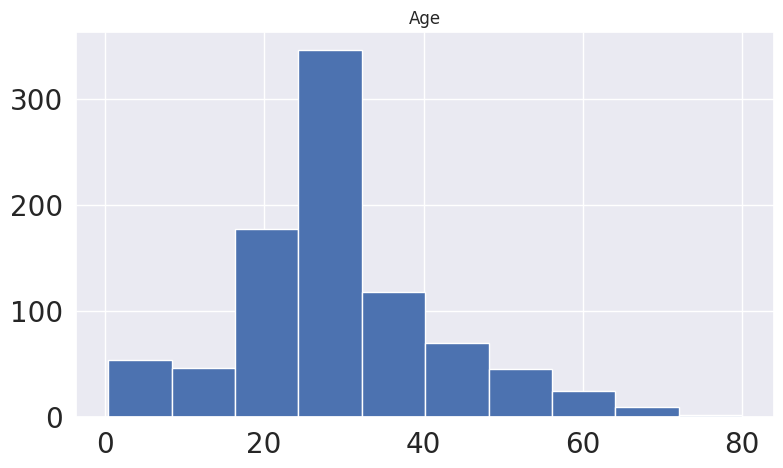

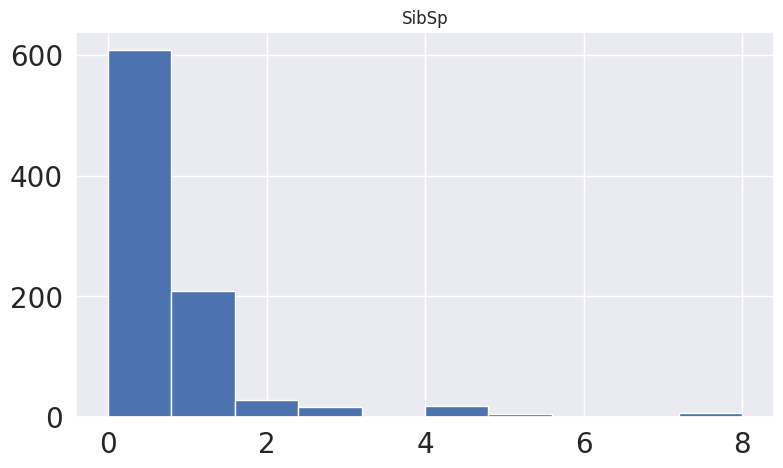

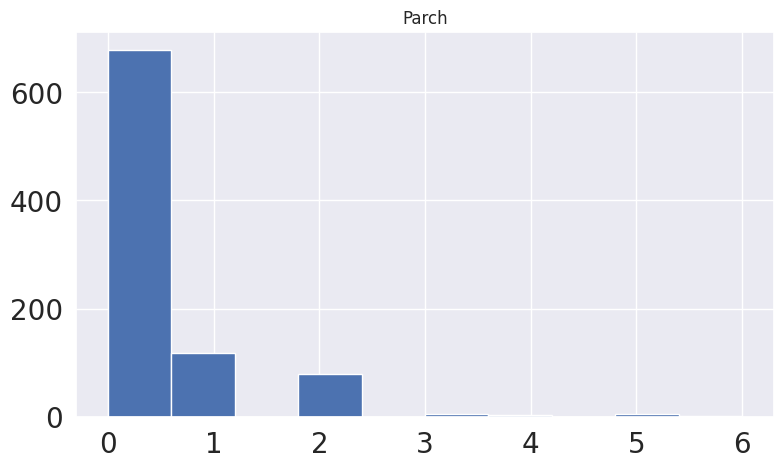

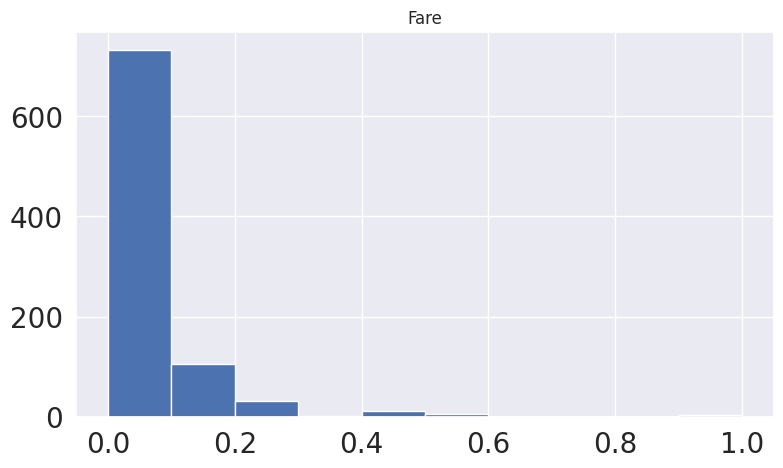

In [118]:
df_num = train_copy.drop(['Survived', 'Sex', 'Embarked', 'Pclass', 'Title'], axis = 1)
#distributions for all numeric variables 
for i in df_num.columns:
    plt.hist(df_num[i])
    plt.title(i)
    plt.show()

<div style="font-size:20px;">
    From the graphs above we can infer the following:
    <br>1. Ages of all passengers distributed closley to the normal distribution
    <br>2. Most passengers traveled alone
</div>

<div style="font-size:20px;">Let's check the survival rates of passengers based on the sex, embarked and Pclass features:</div>

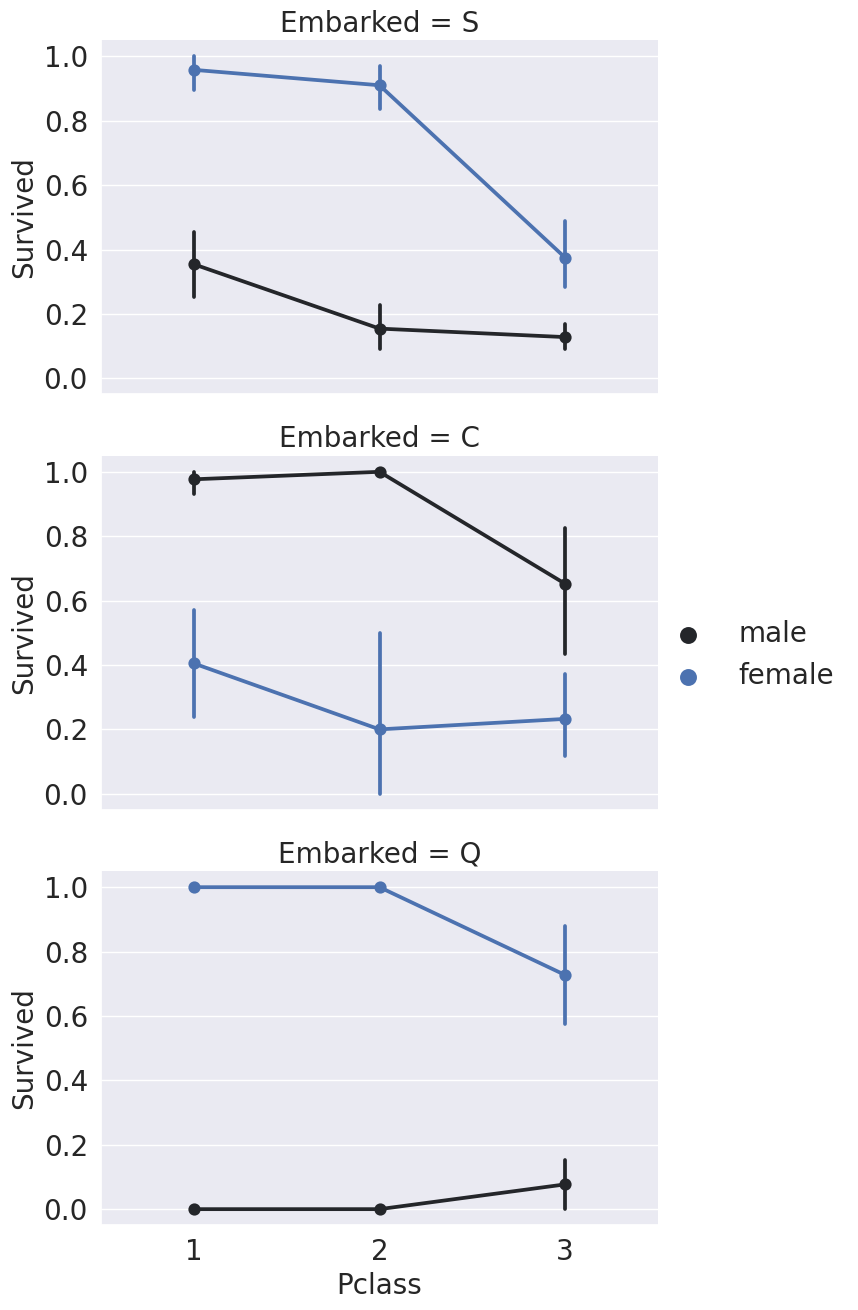

In [119]:
FacetGrid = sns.FacetGrid(train_data, row='Embarked', height=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', order=None, hue_order=None )
FacetGrid.add_legend();

<div style="font-size:20px;">
    <br>The graphs above show:
    <br>1. Women are more likely to survive if they embarked from stations 'Q' or 'S'
    <br>2. Men are more likely to survive if they embarked from station 'C'
    <br>3. Both men and women are more likely to survive if they purchased a higher class ticket.
    <br>This alligns with our earlier findings from the 'Survival by Fare' section.
    <br> That's why we will use all 3 features in the model.
</div>

<div style="font-size:20px;">Let's see the correlation between the variables in the dataframe:</div>

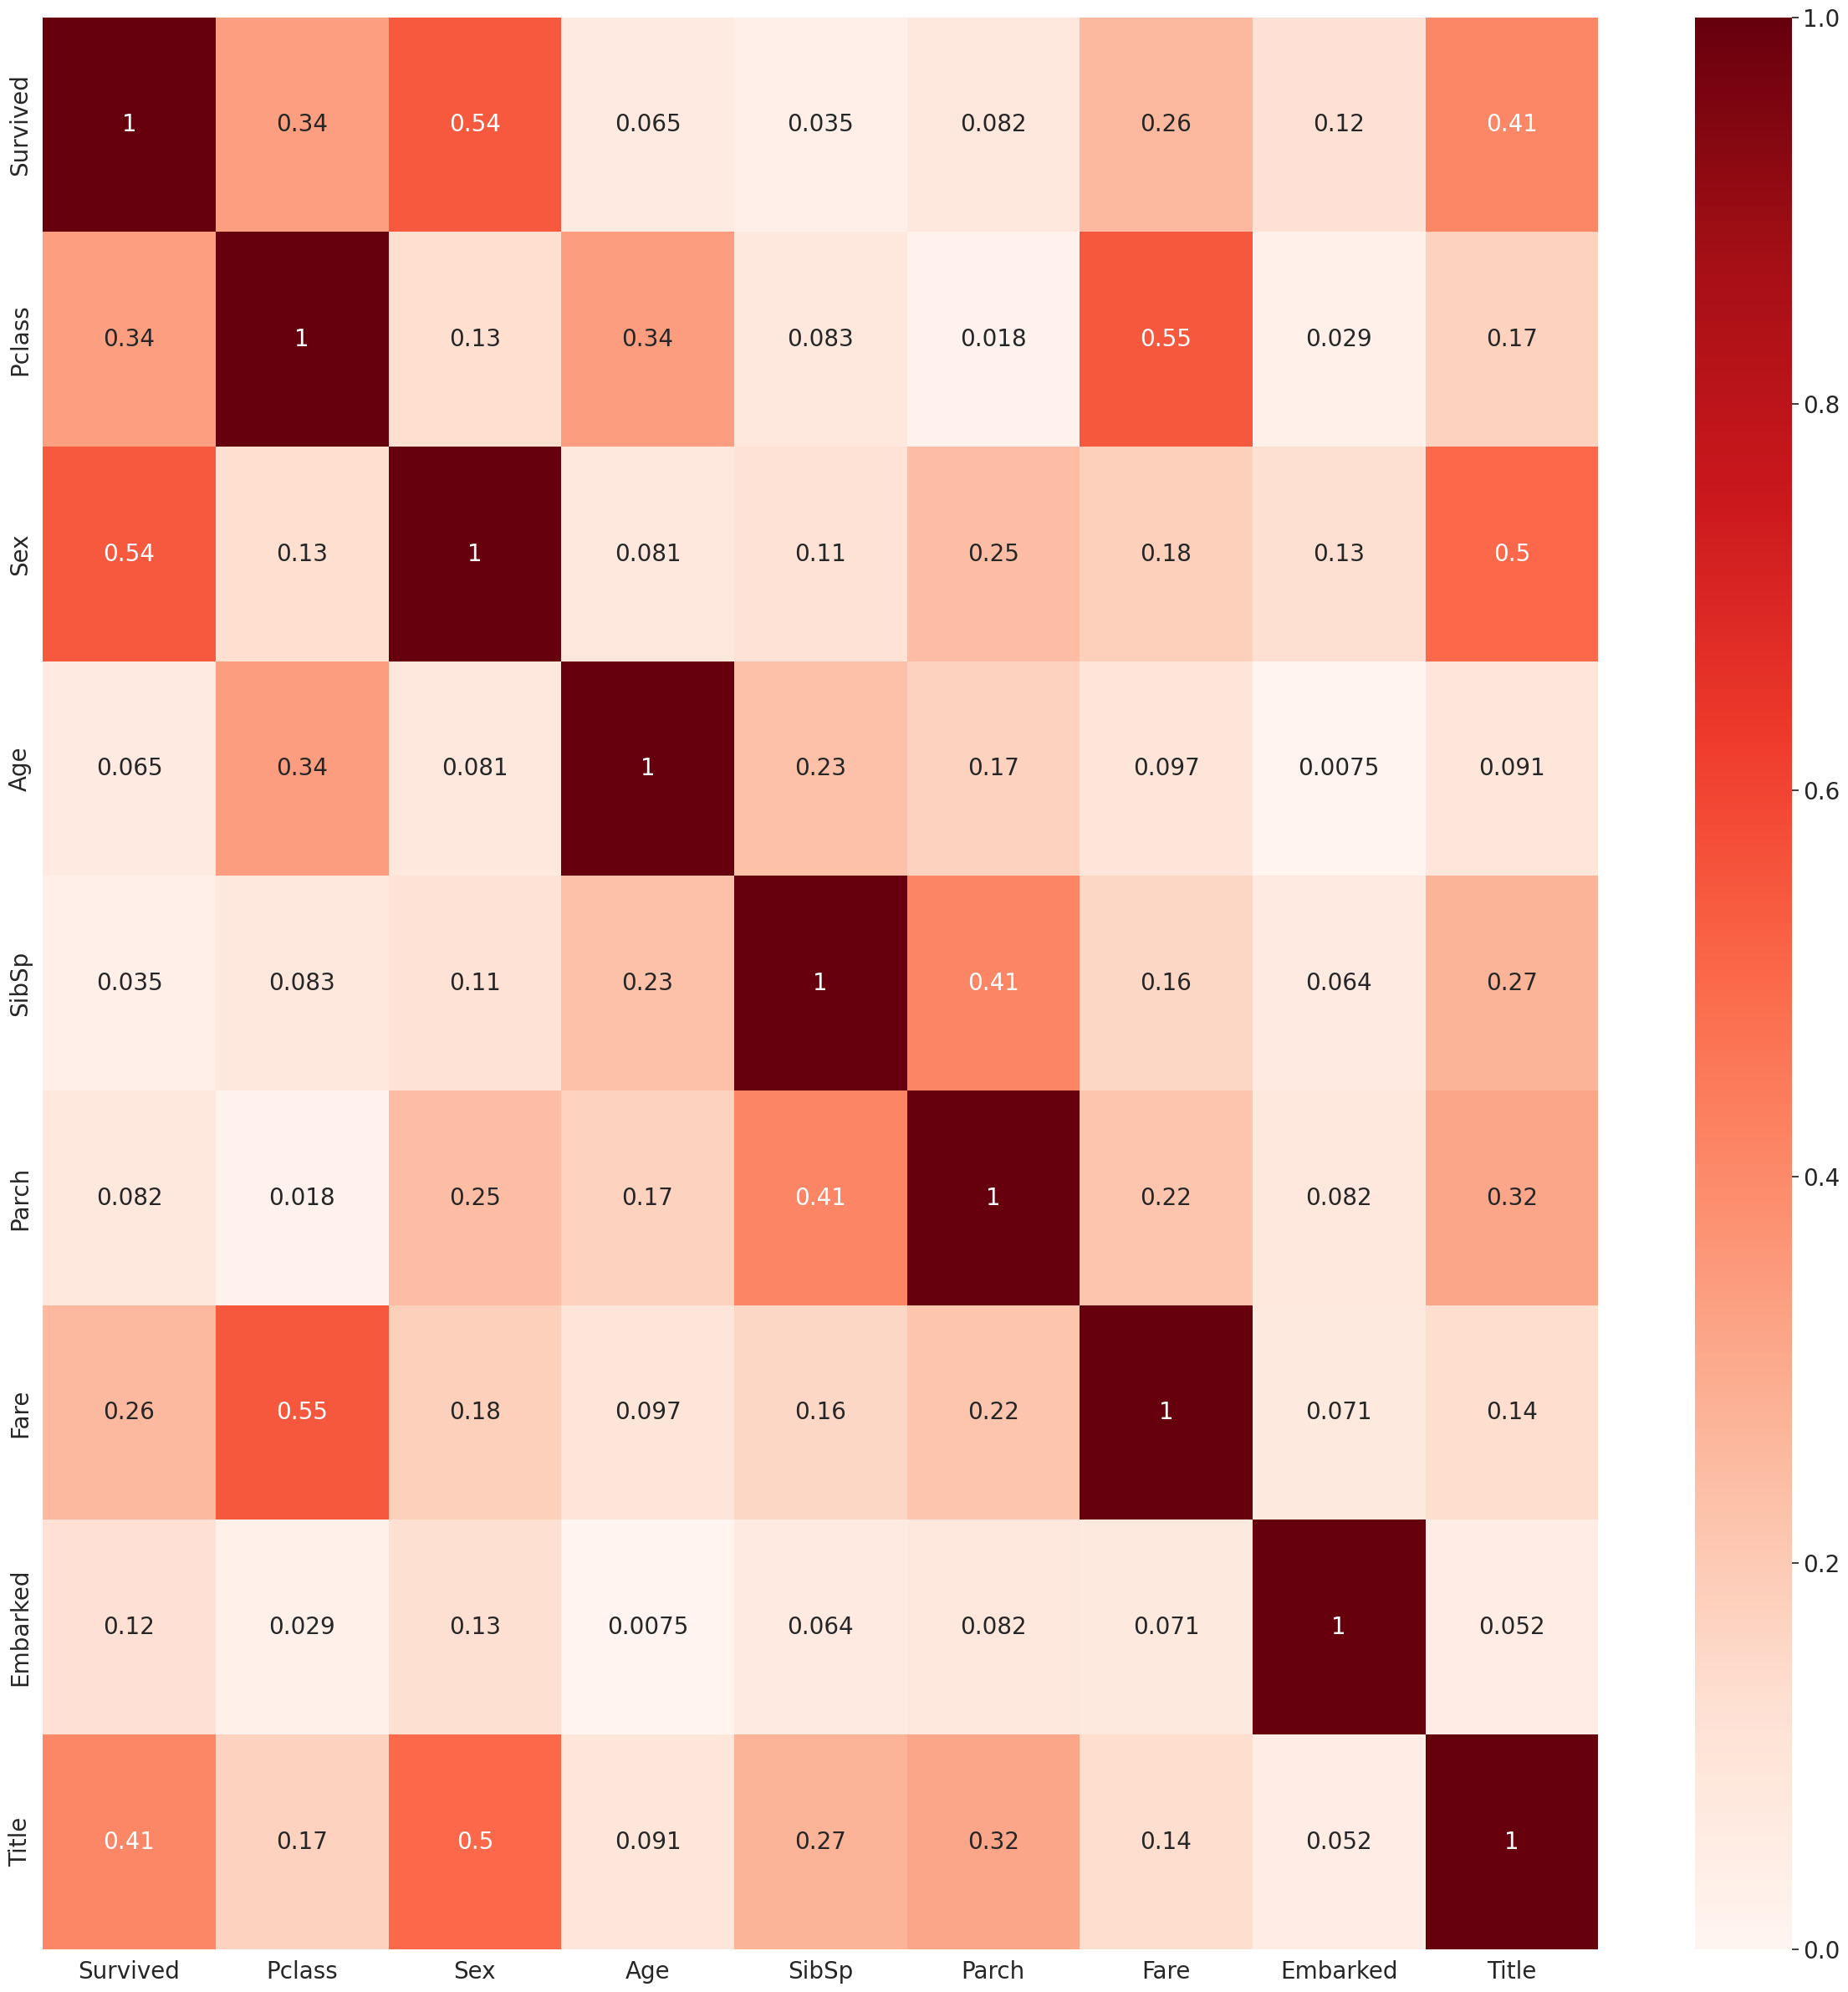

In [120]:
def show_heat_map(data):
    plt.figure(figsize=(30,30))
    cor = np.abs(data.corr())
    sns.heatmap(cor, annot=True, cmap=plt.cm.Reds, vmin=0, vmax=1)
    plt.show()
    
show_heat_map(train_copy)

<div style="font-size:20px;">From this heatmap we can deduce the following:
<br> 1. The Sex, Pclass and Fare features have the highest correlation with the target variable, among all original features.
<br> 2. The Fare and Pclass features are relatively highly correlated. That make sense since a high class ticket should cost more.
<br>Therefore, we might create a new feature involving both Fare and Pclass or consider dropping one of them.
<br> 3. The Age and Pclass features are relatively highly correlated, therefore we might create a new feature involving both of them.
<br> 4. The SibSp and Parch features are relatively highly correlated,therefore we might create a new feature involving both of them.
<br> 5. The Age feature doesn't have a high correlation with the target variable. We suspect this is because of the wide range of values in this column. We might want to categorize these values into groups.
</div>

<div style="font-size:20px;">
 Let's try adding new features based on the above: 
</div>

  AgeGroup  SurvivalRate  SurvivorCount  TotalCount
0     0-10     59.375000             38          64
1    10-20     38.260870             44         115
2    20-30     33.415233            136         407
3    30-40     44.516129             69         155
4    40-50     38.372093             33          86
5    50-60     40.476190             17          42
6    60-70     23.529412              4          17
7      70+     20.000000              1           5



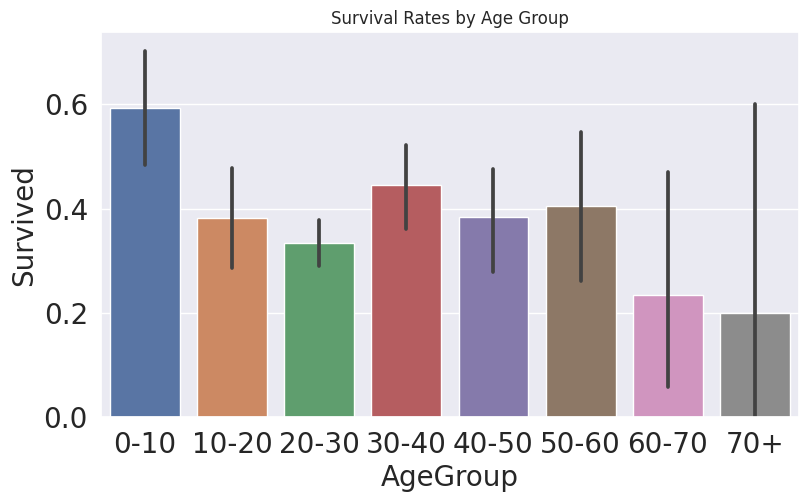

In [121]:
def survRate(data):
    # Group by 'AgeGroup' and calculate survival rates
    age_group_survival_rates = train_copy.groupby('AgeGroup')['Survived'].mean() * 100
    age_group_survival_counts = train_copy.groupby('AgeGroup')['Survived'].sum()
    age_group_total_counts = train_copy.groupby('AgeGroup')['Survived'].count()

    # Combine the results into a DataFrame
    age_group_stats = pd.DataFrame({
        'SurvivalRate': age_group_survival_rates,
        'SurvivorCount': age_group_survival_counts,
        'TotalCount': age_group_total_counts
    }).reset_index()

    # Display the results
    print(age_group_stats)
    print()
    #Age group survival rates
    sns.barplot(x='AgeGroup', y='Survived', data=train_copy)
    plt.title('Survival Rates by Age Group')
    plt.show()
    
bins = [0,10, 20, 30, 40, 50, 60, 70, 100]
labels = ['0-10', '10-20', '20-30', '30-40','40-50', '50-60', '60-70', '70+']
train_copy['AgeGroup'] = pd.cut(train_copy['Age'], bins=bins, labels=labels)
survRate(train_copy)

<div style="font-size:20px;">
 The data provided above indicates that certain age groups are more likely to survive than others.
<br>Therefore we would like to create a feature that takes age group into account.
<br>We can see that passengers between ages 10 - 60 have a similiar survival rate. We will consider them as a single group. Likewise, we will consider passangers aged 60+ as one group as well.
</div>

         AgeGroup  SurvivalRate  SurvivorCount  TotalCount
0        Children     59.375000             38          64
1  Teens / Adults     37.142857            299         805
2         Elderly     22.727273              5          22



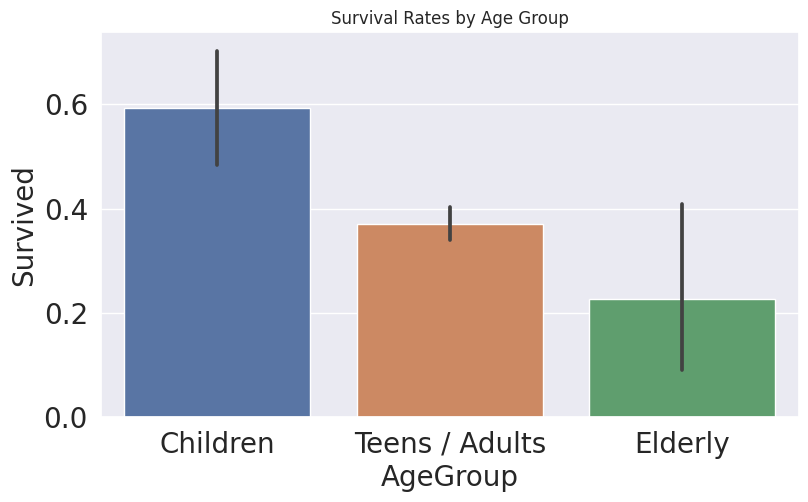

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeGroup
0,0,3,1,22.0,1,0,0.014151,0,1,1
1,1,1,0,38.0,1,0,0.139136,1,3,1
2,1,3,0,26.0,0,0,0.015469,0,2,1
3,1,1,0,35.0,1,0,0.103644,0,3,1
4,0,3,1,35.0,0,0,0.015713,0,1,1
...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.0,0,0,0.025374,0,5,1
887,1,1,0,19.0,0,0,0.058556,0,2,1
888,0,3,0,28.0,1,2,0.045771,0,2,1
889,1,1,1,26.0,0,0,0.058556,1,1,1


In [122]:
bins = [0,10, 60, 100]
labels = ['Children', 'Teens / Adults', 'Elderly']
train_copy['AgeGroup'] = pd.cut(train_copy['Age'], bins=bins, labels=labels) 
survRate(train_copy)
train_copy['AgeGroup'] = pd.to_numeric(train_copy['AgeGroup'].replace({'Children': 0, 'Teens / Adults': 1, 'Elderly': 2}))
display(train_copy)

<div style="font-size:20px;">
We will use the sigmoid function to try and create a feature that better correlates with the target.
We chose to do that since as we can see from the graphs, the children are more likely to survive, and the survival rate "flattens" when moving from children to teens/adults. The sigmoid function is the closest function representing this kind of behavior.
</div>

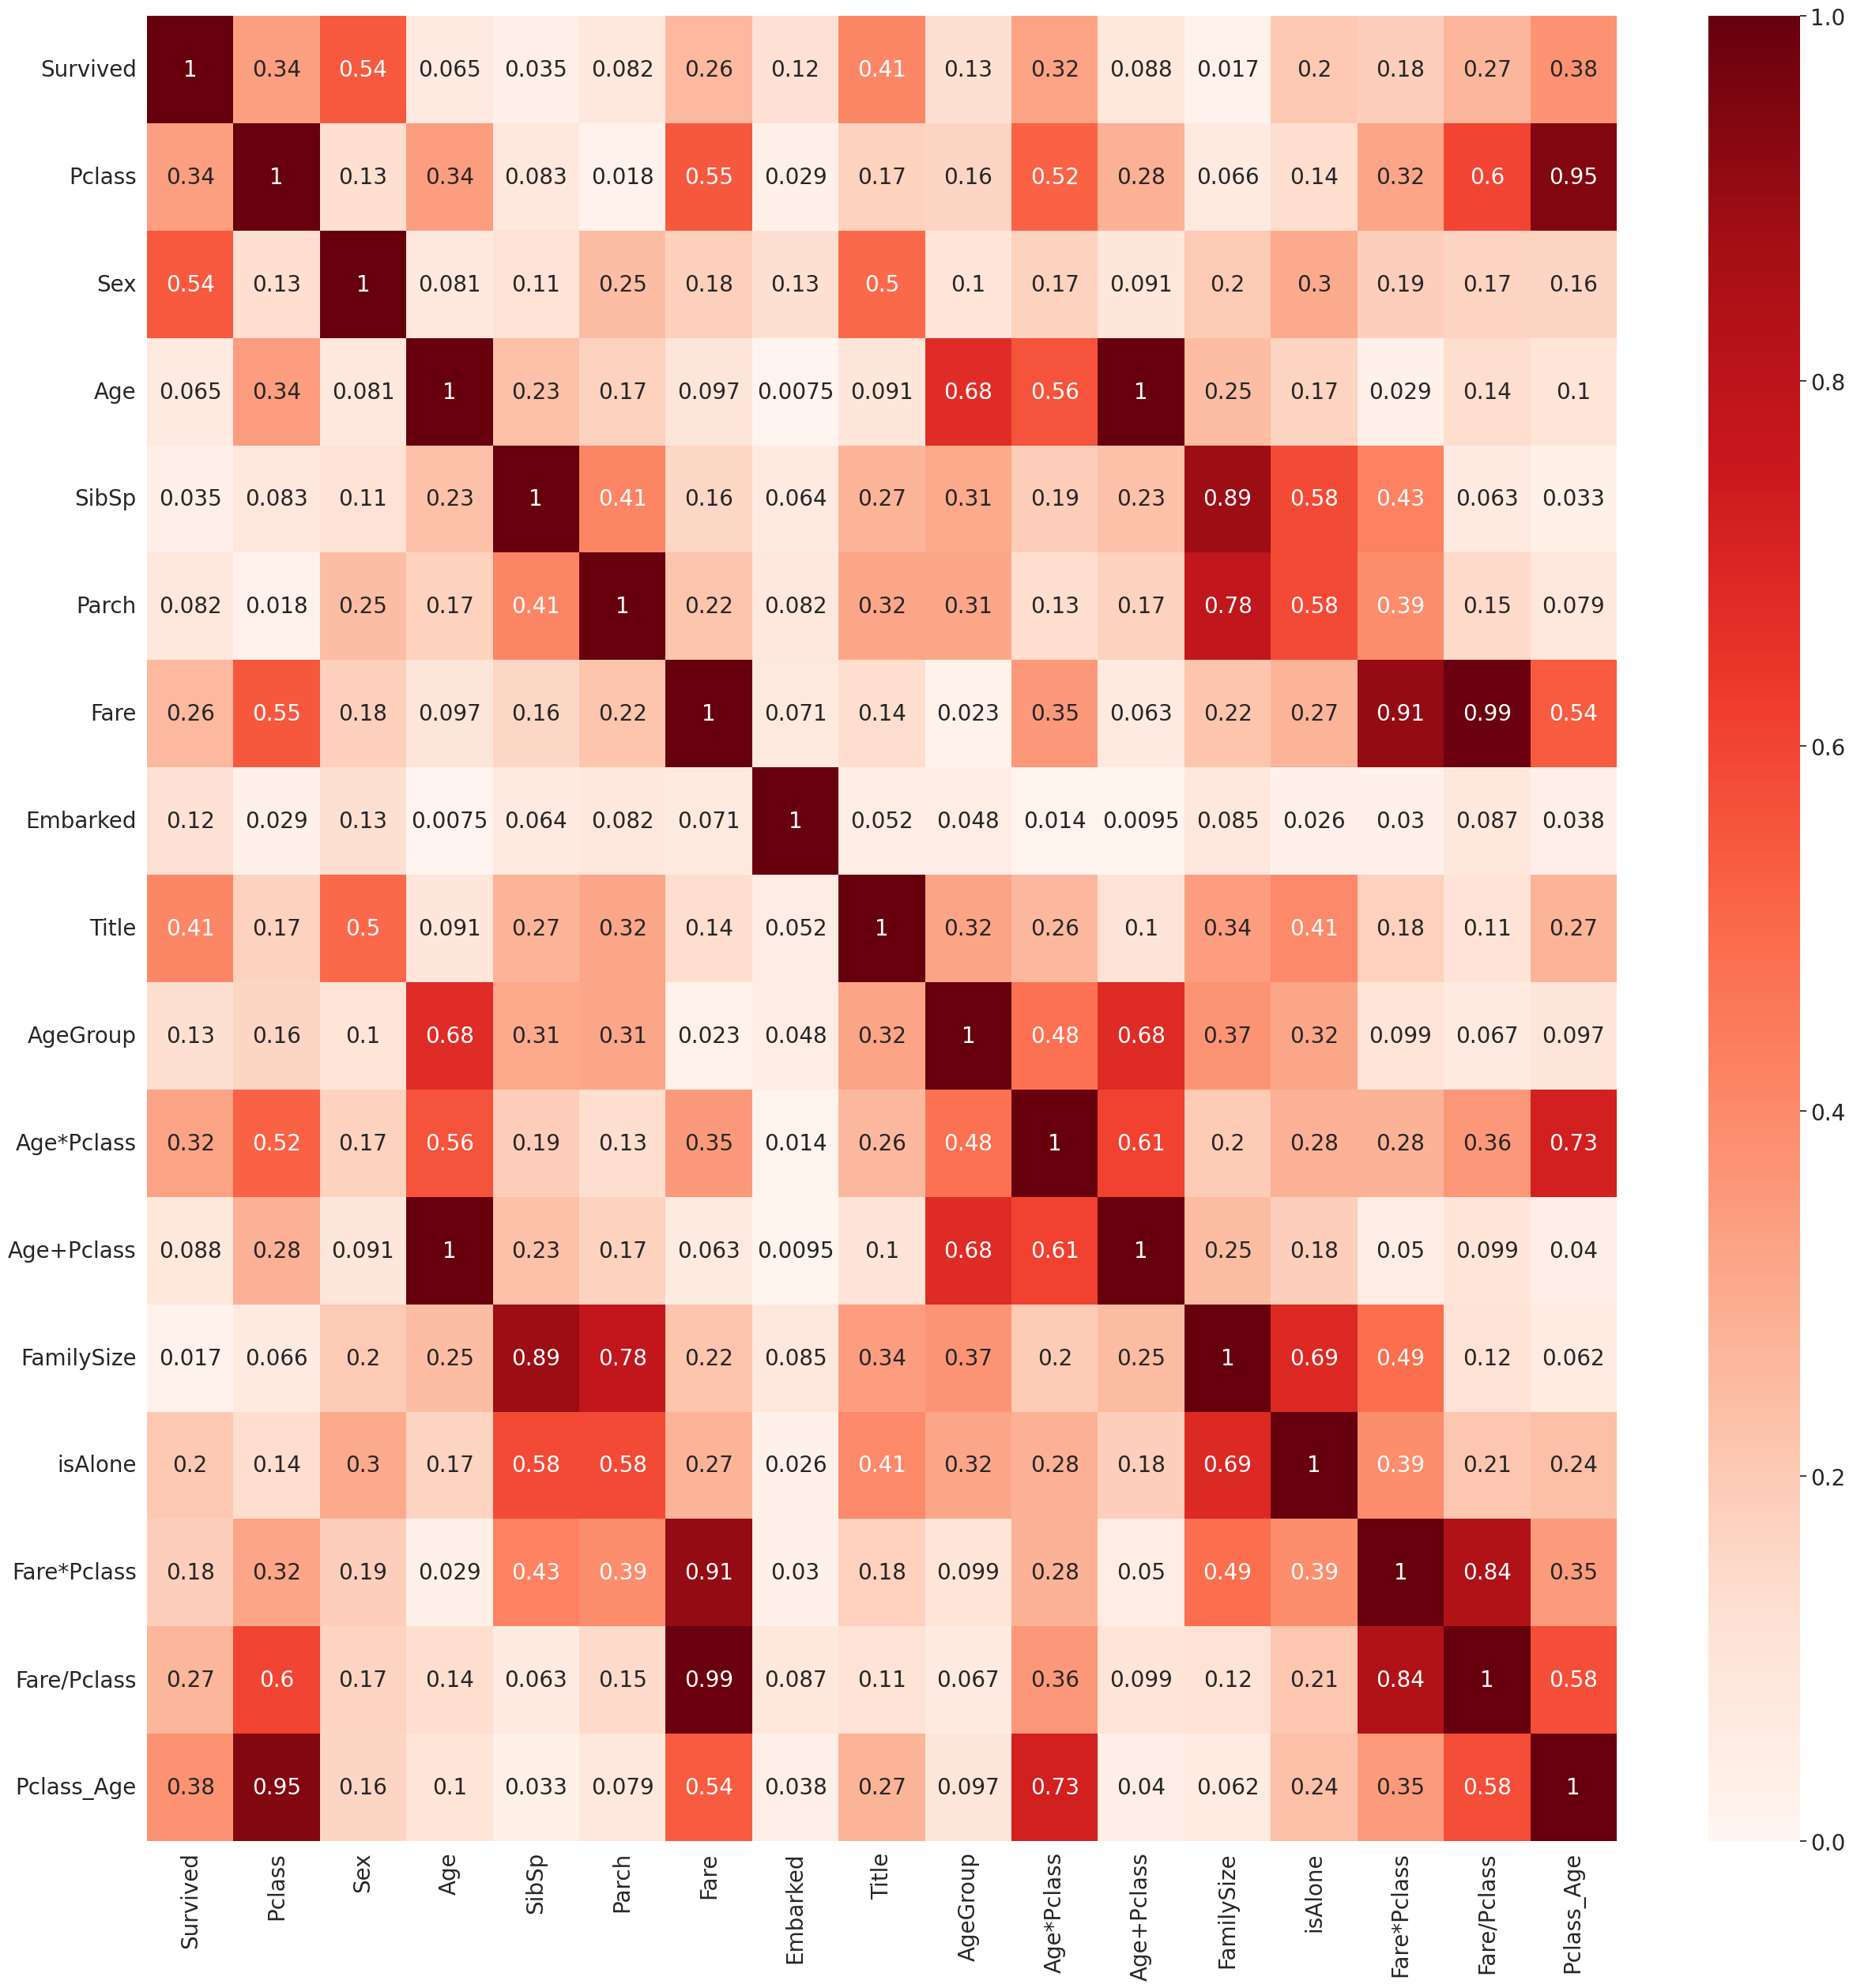

In [123]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
train_copy['Age*Pclass'] = train_copy['Age'] * train_copy['Pclass']
train_copy['Age+Pclass'] = train_copy['Age'] + train_copy['Pclass']
train_copy['FamilySize'] = train_copy['SibSp'] + train_copy['Parch'] + 1
train_copy['isAlone'] = (train_copy['FamilySize'] == 1).astype(int)
train_copy['Fare*Pclass'] = train_copy['Fare'] * train_copy['Pclass']
train_copy['Fare/Pclass'] = train_copy['Fare'] / train_copy['Pclass']
train_copy['Pclass_Age'] = train_copy['Pclass'] * sigmoid(train_copy['Age'] / 10)
show_heat_map(train_copy)

<div style="font-size:20px;">
 We can see that the new 'isAlone' feature is better correlated with the target than SibSp, Parch and family size. We might want to use it over the others.
 We can also see that the Age_Pclass feature is better correlated than pClass.
 Unfotunately, the AgeGroup feature doesn't seem to correlate well with the target.
</div>

<div style="font-size:20px;">
We will now try using different sub groups of the features in the heat map above.
<br> The choosing will be based on the correlation with the target.
<br> The split will be determined by the graphs below.
<br> For each sub group, we will check all models and see what is the highest score.
</div>

In [124]:
def experiment_features(exper_df):
    t = exper_df['Survived']
    X = exper_df.drop('Survived', axis = 1)
    plot_score_and_loss_by_split(X, t)
    return X, t

exper_df = train_copy[['Sex', 'Pclass', 'Fare', 'Title', 'Pclass_Age', 'isAlone', 'Survived']]
X, t = experiment_features(exper_df)

<div style="font-size:20px;">
From the graphs above:
<br> LR - 0.1 for test is a good split. Reasoning: minimal loss and max score for train and good score in val and a decent value of loss.
<br> SGD - 0.1 for test is a good split. Reasoning: best scores and best losses in both train and val.
<br> MLP - 0.3 for test is a good split. Reasoning: good values for loss and score in both train and val.
</div>

In [125]:
calcScore(0.1, 0.1, 0.3, X, t)

,Model,Train Score,Validation Score
0,Logistic Regression,0.796504,0.800000
1,SGD Classifier,0.792759,0.788889
2,MLP,0.789727,0.764925


<div style="font-size:20px;">
Let's try dropping the Title and add Embarked
</div>

In [126]:
exper_df = train_copy[['Sex', 'Pclass', 'Fare', 'Embarked', 'Pclass_Age', 'isAlone', 'Survived']]
X, t = experiment_features(exper_df)

<div style="font-size:20px;">
From the graphs above:
<br> LR - 0.1 for test is a good split. Reasoning: best scores and best losses in both train and val.
<br> SGD - 0.1 for test is a good split. Reasoning: best scores and best losses in both train and val.
<br> MLP - 0.3 for test is a good split. Reasoning: decent values for loss and score in both train and val. 
</div>

In [127]:
calcScore(0.1, 0.1, 0.15, X, t)

,Model,Train Score,Validation Score
0,Logistic Regression,0.794007,0.833333
1,SGD Classifier,0.796504,0.833333
2,MLP,0.782034,0.776119


<div style="font-size:20px;">
Let's try including both Title and Embarked:
</div>

In [128]:
exper_df = train_copy[['Sex', 'Pclass', 'Fare', 'Embarked','Title', 'Pclass_Age', 'isAlone', 'Survived']]
X, t = experiment_features(exper_df)

<div style="font-size:20px;">
From the graphs above:
<br> LR - 0.1 for test is a good split. Reasoning: minimal loss and max score for train and good score in val and a decent value of loss.
<br> SGD - 0.1 for test is a good split. Reasoning: minimal loss and max score for train and minimal loss and a close to max score in val
<br> MLP - 0.3 for test is a good split. Reasoning: good values for loss and score in both train and val. 
</div>

In [129]:

calcScore(0.1, 0.1, 0.3, X, t)

,Model,Train Score,Validation Score
0,Logistic Regression,0.803995,0.788889
1,SGD Classifier,0.799001,0.788889
2,MLP,0.783307,0.761194


<div style="font-size:20px;">
Let's try removing Pclass to prevent overfitting:
</div>

In [130]:
exper_df = train_copy[['Sex', 'Fare', 'Embarked', 'isAlone', 'Pclass_Age', 'Survived']]
X, t = experiment_features(exper_df)

<div style="font-size:20px;">
From the graphs above:
<br> LR - 0.1 for test is a good split. Reasoning: best scores and best losses in both train and val.
<br> SGD - 0.1 for test is a good split. Reasoning: best scores and best losses in both train and val.
<br> MLP - 0.2 for test is a good split. Reasoning: good values for loss and score in both train and val. 
</div>

In [131]:
calcScore(0.1, 0.1, 0.2, X, t)

,Model,Train Score,Validation Score
0,Logistic Regression,0.790262,0.833333
1,SGD Classifier,0.789014,0.822222
2,MLP,0.804775,0.810056


<div style="font-size:20px;">
 We got the highest score with Logistic Regression with the last set of features. We will use it for our submission:
</div>

In [132]:
train_copy.drop(['AgeGroup', 'FamilySize','Age*Pclass','Age+Pclass', 'Fare*Pclass', 'Fare/Pclass', 'SibSp', 'Parch',  'Age', 'Title'], axis = 1, inplace = True)

<div style="font-size:20px;">
We need to modify the test dataframe to match our train dataframe:
</div>

In [133]:
test_copy['FamilySize'] = test_copy['SibSp'] + test_copy['Parch'] + 1
test_copy['isAlone'] = (test_copy['FamilySize'] == 1).astype(int)
test_copy['Pclass_Age'] = test_copy['Pclass'] * sigmoid(test_copy['Age'] / 10)
test_copy.drop(['FamilySize', 'SibSp', 'Parch',  'Age', 'Title'], axis = 1, inplace = True)

In [134]:
t = train_copy['Survived'].copy()
X = train_copy.drop(['Survived'], axis = 1)

In [135]:
lr = LogisticRegression()
lr.fit(X, t)
prediction = lr.predict(test_copy)
test_ID = test_data['PassengerId']
submission = pd.DataFrame({"PassengerId": test_ID.values, "Survived": prediction})
submission.to_csv("submissionLR.csv", index = False)

<div style="font-size:20px;"> Submissions and Leaderboard:</div>

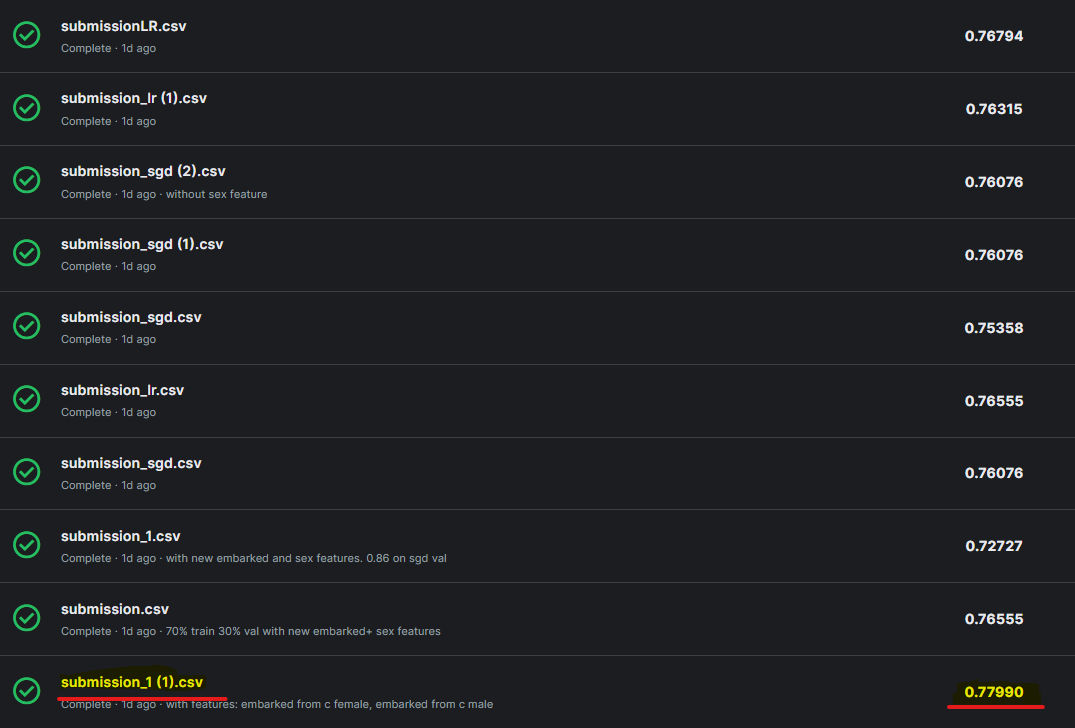

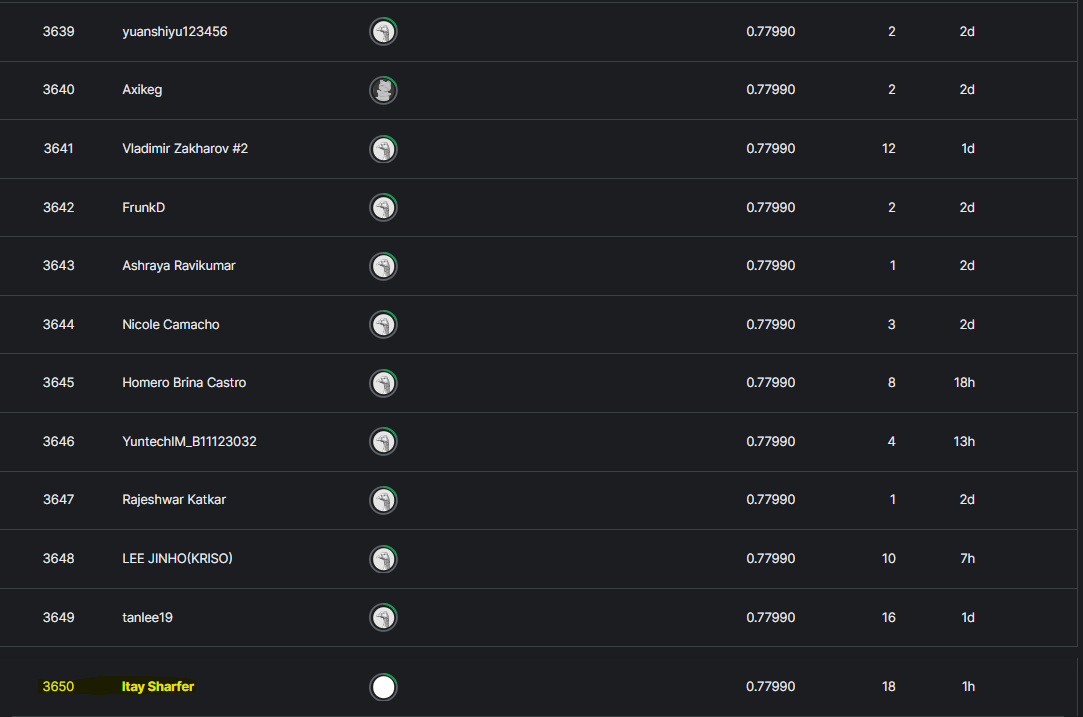

<div style="font-size:30px;"> Summary:</div>

<div style="font-size:20px;"> 
     After exploring the data we can deduce the following:
<br> The sex of a passenger had big impact on survival chance: Women had higher survival rates than men.
<br> Another factor that played a role in survival chance is the age of a passenger. Children were more likely to survive than adults.
<br> Another thing that stood out is the fact that higher paying passengers were also more likely to survive than lower paying ones.
<br> This makes sense because we've also seen that passengers who purchased a higher class ticket were more likely to survive.
<br> At first we thought the location of embarkment wouldn't have any impact on survival chance of a passenger.
<br> After examining the data, we were surprised to find out that there was a correlation between survival and the boarding location.
<br> We also saw that there's a relation between the fact that a passenger traveled alone to his survival chance.
<br> As for the models we tested, we noticed that SGD classifier and Logistic Regression performed similiarly well while MLP usually performed worse.
</div>

<div style="font-size:30px;"> References:</div>

<div style="font-size:20px;">
    Data analysis:
<br>1. <a href="https://www.kaggle.com/code/startupsci/titanic-data-science-solutions/notebook">Kaggle notebook</a>
<br>2. <a href="https://www.kaggle.com/code/kenjee/titanic-project-example">Kaggle notebook</a>
<br>Video walkthrough:
<br>3 .<a href="https://www.youtube.com/watch?v=pUSi5xexT4Q&t=559s&ab_channel=AladdinPersson">video</a>
<br>4. <a href="https://www.youtube.com/watch?v=I3FBJdiExcg&t=613s&ab_channel=KenJee">video</a>
<br> Python functions and library functions were taken from the notebooks provided by the course.
</div>

# **Exercise 3**

<div style="font-size:30px;"> TLDR:</div>

<div style="font-size:20px;">
    In this exercise we aimed to improve the score of our submission from exercise 1.
    <br> To achieve that, we used CV and experminted with different models (KNN, LDA, NBC), feature selection methods, hyper parameters fine tuning algorithms and ensembles.
    <br> After getting the best results, we've submitted our best model's prediction to the competition
</div>

In [83]:
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, MinMaxScaler
from sklearn.linear_model import SGDClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.model_selection import cross_val_score, GridSearchCV, RepeatedKFold, KFold, LeavePOut
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.feature_selection import RFECV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import metrics
from tqdm.auto import tqdm
import seaborn as sns


#ignore future warnings
import warnings
warnings.filterwarnings('ignore')

<div style="font-size:20px;">
Funcntions for later use:
</div>

In [84]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def add_features(data):
    data['AgePclass'] = data['Age'] * data['Pclass']
    data['Age+Pclass'] = data['Age'] + data['Pclass']
    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
    data['isAlone'] = (data['FamilySize'] == 1).astype(int)
    data['FarePclass'] = data['Fare'] * data['Pclass']
    data['Fare/Pclass'] = data['Fare'] / data['Pclass']
    data['Pclass_Age'] = data['Pclass'] * sigmoid(data['Age'] / 10)
    return data

#used to deal with null values, add new features, scale the numeric data and encode the categorical data
def preprocess(df, numeric_features, categorical_features):
    numeric_transformer_impute = SimpleImputer(strategy='mean')
    categorical_transformer_impute = SimpleImputer(strategy='most_frequent')

    df[numeric_features] = numeric_transformer_impute.fit_transform(df[numeric_features])
    df[categorical_features] = categorical_transformer_impute.fit_transform(df[categorical_features])
    
    df = add_features(df)
    
    additional_numeric_features = ['AgePclass', 'Age+Pclass', 'FamilySize', 'isAlone', 'FarePclass', 'Fare/Pclass', 'Pclass_Age']
    numeric_features.extend(additional_numeric_features)
    
    numeric_transformer = Pipeline(steps=[
        ('scaler', MinMaxScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )
    
    df_preprocessed = preprocessor.fit_transform(df)

    numeric_feature_names = numeric_features
    categorical_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
    feature_names = list(numeric_feature_names) + list(categorical_feature_names)
    df_preprocessed = pd.DataFrame(df_preprocessed, columns=feature_names)

    return df_preprocessed

def find_generator_len(generator, use_pbar=True):
    i = 0
    
    if use_pbar:
        pbar = tqdm(desc='Calculating Length', ncols=1000, bar_format='{desc}{bar:10}{r_bar}')

    for a in generator:
        i += 1

        if use_pbar:
            pbar.update()

    if use_pbar:
        pbar.close()

    return i

def precision(cm):
    tn, fp, fn, tp = cm.ravel()
    return tp/(tp+fp)

def recall(cm):
    tn, fp, fn, tp = cm.ravel()
    return tp/(tp+fn)

def specificity(cm):
    tn, fp, fn, tp = cm.ravel()
    return tn/(tn+fp)

def fpr(cm):
    tn, fp, fn, tp = cm.ravel()
    return fp/(fp+tn)

def accuracy(cm):
    tn, fp, fn, tp = cm.ravel()
    return (tp+tn)/(tp+tn+fp+fn)

# calculate f1 and balanced accuracy
def f1(cm):
    precision_calc = precision(cm)
    recall_calc = recall(cm)
    return (2*precision_calc*recall_calc)/(precision_calc+recall_calc)

def balanced_accuracy(cm):
    recall_calc = recall(cm)
    specificity_calc = specificity(cm)
    return (recall_calc+specificity_calc)/2

def calc_metrics(cm):
    return {
      'precision': precision(cm),
      'recall': recall(cm),
      'specificity': specificity(cm),
      'fpr': fpr(cm),
      'accuracy': accuracy(cm),
      'f1': f1(cm),
      'balanced accuracy': balanced_accuracy(cm),
  }

def print_confusion_matrix(model, cm_train, cm_val):
    cm_train_df = pd.DataFrame(cm_train, index=['actual_0', 'actual_1'], columns=['predicted_0', 'predicted_1'])
    cm_val_df = pd.DataFrame(cm_val, index=['actual_0', 'actual_1'], columns=['predicted_0', 'predicted_1'])

    print('Confusion Matrix')
    fig, ax = plt.subplots(ncols=2, figsize=(5, 3))
    
    for i, (df, title) in enumerate(zip([cm_train_df, cm_val_df], ['Train', 'Validation'])):
        fig = sns.heatmap(df, annot=True, ax=ax[i], cmap='Blues', fmt='d')
        fig.set_title(title)
    
    plt.subplots_adjust(top=1.5, bottom=0, left=0, right=2)
    plt.show()

    metrics = pd.DataFrame({'Train': calc_metrics(cm_train), 'Validation': calc_metrics(cm_val)})
    display(metrics)

In [85]:
def get_cv_score_and_loss(X, t, model, k=None, p=None, show_score_loss_graphs=False, use_pbar=True):
    scores_losses_df = pd.DataFrame(columns=['fold_id', 'split', 'score', 'loss'])

    if k is not None:
        cv = KFold(n_splits=k, shuffle=True, random_state=42)
    elif p is not None:
        cv = LeavePOut(p)
    else:
        raise ValueError('You need to specify k or p for the CV to work.')

    if use_pbar:
        pbar = tqdm(desc='Computing Models', total=cv.get_n_splits(X))

    # Initialize lists to store metrics
    all_true_labels = []
    all_predictions = []

    for i, (train_ids, val_ids) in enumerate(cv.split(X)):
        X_train = X.iloc[train_ids]
        t_train = t.iloc[train_ids]
        X_val = X.iloc[val_ids]
        t_val = t.iloc[val_ids]

        model.fit(X_train, t_train)

        y_train = model.predict(X_train)
        y_val = model.predict(X_val)

        # Store metrics for each fold
        all_true_labels.extend(t_val)
        all_predictions.extend(y_val)

        scores_losses_df.loc[len(scores_losses_df)] = [i, 'train', model.score(X_train, t_train), 1 - accuracy_score(t_train, y_train)]
        scores_losses_df.loc[len(scores_losses_df)] = [i, 'val', model.score(X_val, t_val), 1 - accuracy_score(t_val, y_val)]

        if use_pbar:
            pbar.update()

    if use_pbar:
        pbar.close()

    # Compute confusion matrix
    conf_mat = confusion_matrix(all_true_labels, all_predictions)

    # Plot confusion matrix
    plt.figure(figsize=(7,5))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    TN, FP, FN, TP = conf_mat.ravel()

    # Calculate precision, recall, and F1-score
    precision = precision_score(all_true_labels, all_predictions)
    recall = recall_score(all_true_labels, all_predictions)
    f1 = f1_score(all_true_labels, all_predictions)

    # Calculate FPR and Specificity
    fpr = FP / (FP + TN)
    specificity = TN / (TN + FP)
    # Print KPIs
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1-score: {f1:.2f}')
    print(f'False Positive Rate (FPR): {fpr:.2f}')
    print(f'Specificity: {specificity:.2f}')

    val_scores_losses_df = scores_losses_df[scores_losses_df['split'] == 'val']
    train_scores_losses_df = scores_losses_df[scores_losses_df['split'] == 'train']

    mean_val_score = val_scores_losses_df['score'].mean()
    mean_val_loss = val_scores_losses_df['loss'].mean()
    mean_train_score = train_scores_losses_df['score'].mean()
    mean_train_loss = train_scores_losses_df['loss'].mean()

    if show_score_loss_graphs:
        fig, axs = plt.subplots(2, 1, figsize=(10, 8))

        for split, group in scores_losses_df.groupby('split'):
            if split == 'train':
                color = 'blue'
            else:
                color = 'red'
            axs[0].plot(group['fold_id'], group['score'], label=f'{split} score', color=color)
            axs[1].plot(group['fold_id'], group['loss'], label=f'{split} loss', color=color)

        axs[0].set_title(f'Mean Val Score: {mean_val_score:.2f}, Mean Train Score: {mean_train_score:.2f}')
        axs[0].set_xlabel('Fold ID')
        axs[0].set_ylabel('Score')
        axs[0].legend()

        axs[1].set_title(f'Mean Val Loss: {mean_val_loss:.2f}, Mean Train Loss: {mean_train_loss:.2f}')
        axs[1].set_xlabel('Fold ID')
        axs[1].set_ylabel('Loss')
        axs[1].legend()

        plt.tight_layout()
        plt.show()

    return mean_val_score, mean_val_loss, mean_train_score, mean_train_loss

def estimate(X, t, model):
    val_score, val_loss, train_score, train_loss = get_cv_score_and_loss(X, t, model, k=5, p=None, show_score_loss_graphs=True, use_pbar=True)
    print(f'mean cv val score: {val_score:.2f}\nmean cv val loss {val_loss:.2f}')
    print(f'mean cv val score: {train_score:.2f}\nmean cv val loss {train_loss:.2f}')

<div style="font-size:20px;">The data is being preprocessed based on our findings from exercise 1:</div>

In [86]:
# Load the data
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
train_data = train_data.drop(columns=['Cabin', 'Name'])

# Define numerical and categorical features
num_features = ['Age', 'Fare', 'SibSp', 'Parch']
cat_features = ['Pclass', 'Sex', 'Embarked']

X_train = train_data.drop(columns=['Survived'])
t = train_data['Survived']

# Fit and transform the training data
X_train_enc = preprocess(X_train, num_features, cat_features)
print('Train:')
display(X_train_enc)

num_features_test = ['Age', 'Fare', 'SibSp', 'Parch']
cat_features_test = ['Pclass', 'Sex', 'Embarked']
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')
test_data = test_data.drop(columns=['Cabin', 'Name'])
test_enc = preprocess(test_data, num_features_test, cat_features_test)
print('Test:')
display(test_enc)



Train:


,Age,Fare,SibSp,Parch,AgePclass,Age+Pclass,FamilySize,isAlone,FarePclass,Fare/Pclass,Pclass_Age,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0.271174,0.014151,0.125,0.000000,0.294373,0.291856,0.1,0.0,0.042453,0.004717,0.879840,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,0.472229,0.139136,0.125,0.000000,0.167722,0.468892,0.1,0.0,0.139136,0.139136,0.183879,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.321438,0.015469,0.000,0.000000,0.348652,0.342438,0.0,1.0,0.046406,0.005156,0.916942,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,0.434531,0.103644,0.125,0.000000,0.154152,0.430956,0.1,0.0,0.103644,0.103644,0.180877,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.434531,0.015713,0.000,0.000000,0.470780,0.456247,0.0,1.0,0.047138,0.005238,0.965213,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.334004,0.025374,0.000,0.000000,0.240094,0.342438,0.0,1.0,0.050749,0.012687,0.545846,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
887,0.233476,0.058556,0.000,0.000000,0.081780,0.228629,0.0,1.0,0.058556,0.058556,0.140154,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
888,0.367921,0.045771,0.125,0.333333,0.398848,0.389215,0.3,0.0,0.137314,0.015257,0.941589,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
889,0.321438,0.058556,0.000,0.000000,0.113443,0.317147,0.0,1.0,0.058556,0.058556,0.164787,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


Test:


,Age,Fare,SibSp,Parch,AgePclass,Age+Pclass,FamilySize,isAlone,FarePclass,Fare/Pclass,Pclass_Age,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0.452723,0.015282,0.000,0.000000,0.569037,0.466793,0.0,1.0,0.045845,0.005094,0.963682,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.617566,0.013663,0.125,0.000000,0.776231,0.635529,0.1,0.0,0.040989,0.004554,0.991487,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
2,0.815377,0.018909,0.000,0.000000,0.682303,0.824514,0.0,1.0,0.037817,0.009454,0.575257,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.353818,0.016908,0.000,0.000000,0.444721,0.365551,0.0,1.0,0.050724,0.005636,0.922522,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0.287881,0.023984,0.125,0.111111,0.361843,0.298056,0.2,0.0,0.071951,0.007995,0.875518,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0.396975,0.015713,0.000,0.000000,0.498966,0.409727,0.0,1.0,0.047138,0.005238,0.943947,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
414,0.512066,0.212559,0.000,0.000000,0.212664,0.500540,0.0,1.0,0.212559,0.212559,0.142506,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
415,0.505473,0.014151,0.000,0.000000,0.635339,0.520788,0.0,1.0,0.042453,0.004717,0.976376,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
416,0.396975,0.015713,0.000,0.000000,0.498966,0.409727,0.0,1.0,0.047138,0.005238,0.943947,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


<div style="font-size:30px;">Model Selection:</div>

<div style="font-size:20px;">In this section we will use it to choose between the NBC, LDA and KNN algorithms.</div>

<div style="font-size:20px;">First, we will try using the Naive Bayes. Since the features don't satisfy the naive assumption, we believe we will have more luck with KNN or with LDA</div>

Accuracy score for classification:
gs_model 0.7879543029313917
best params {'pca': PCA(n_components=8), 'pca__n_components': 8}


Computing Models:   0%|          | 0/5 [00:00<?, ?it/s]

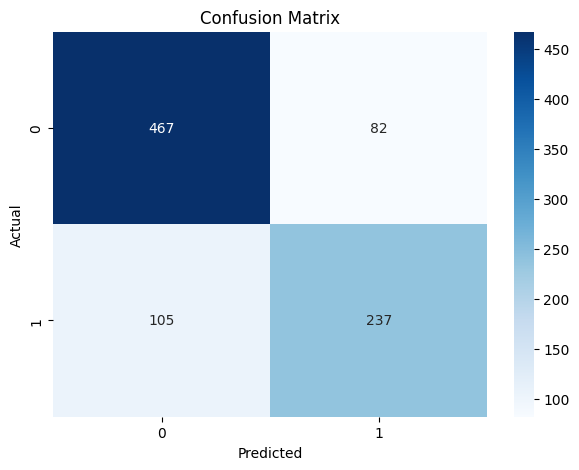

Precision: 0.74
Recall: 0.69
F1-score: 0.72
False Positive Rate (FPR): 0.15
Specificity: 0.85


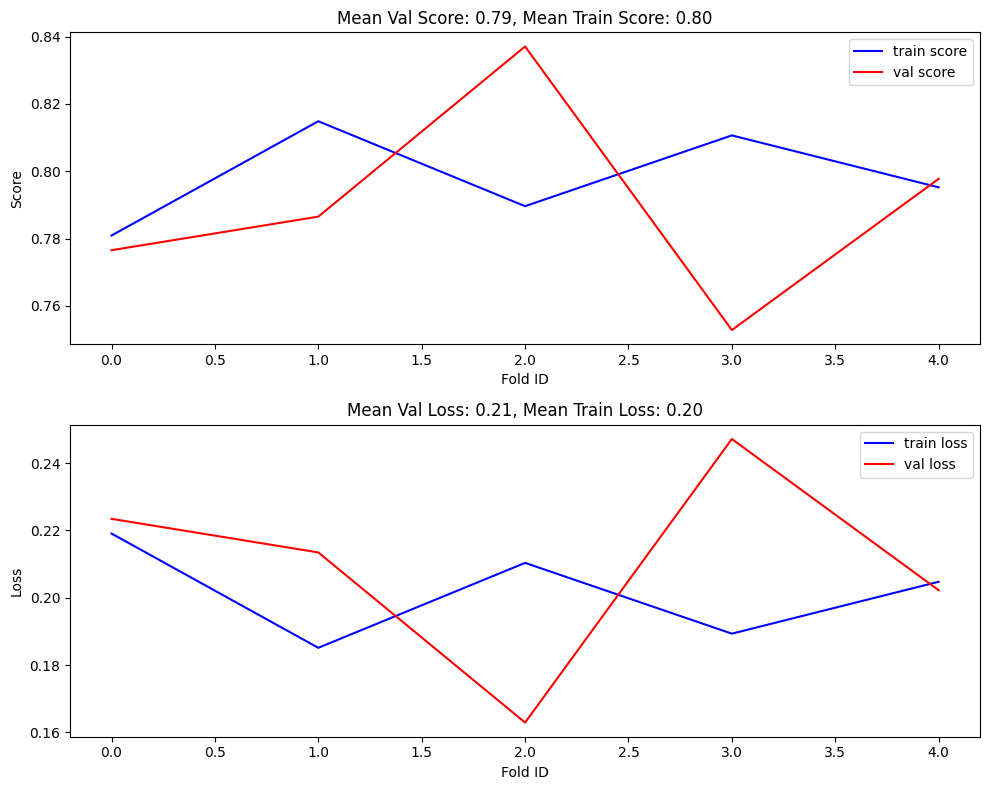

mean cv val score: 0.79
mean cv val loss 0.21
mean cv val score: 0.80
mean cv val loss 0.20


In [87]:
model_pipe = Pipeline([('pca', 'passthrough'),
                       ('nbc', GaussianNB())])

hyper_parameters = {'pca': [PCA()],
                    'pca__n_components': list(range(1, len(X_train_enc.columns)-3))}

gs_model = GridSearchCV(model_pipe, hyper_parameters).fit(X_train_enc, t)

print('Accuracy score for classification:')
print('gs_model', gs_model.best_score_)
print('best params', gs_model.best_params_)

estimate(X_train_enc, t, gs_model)

<div style="font-size:20px;">Now let's try using K- nearest neighbors with gridSearch to try and get a better result:</div>

Accuracy score for classification:
gs_neigh_model 0.8070052099679869
best params {'n_neighbors': 4}


Computing Models:   0%|          | 0/5 [00:00<?, ?it/s]

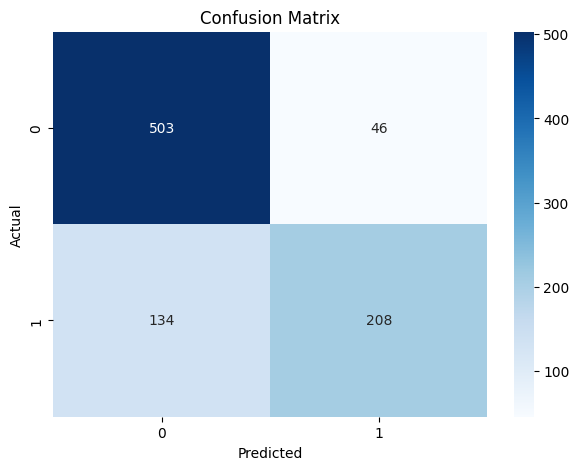

Precision: 0.82
Recall: 0.61
F1-score: 0.70
False Positive Rate (FPR): 0.08
Specificity: 0.92


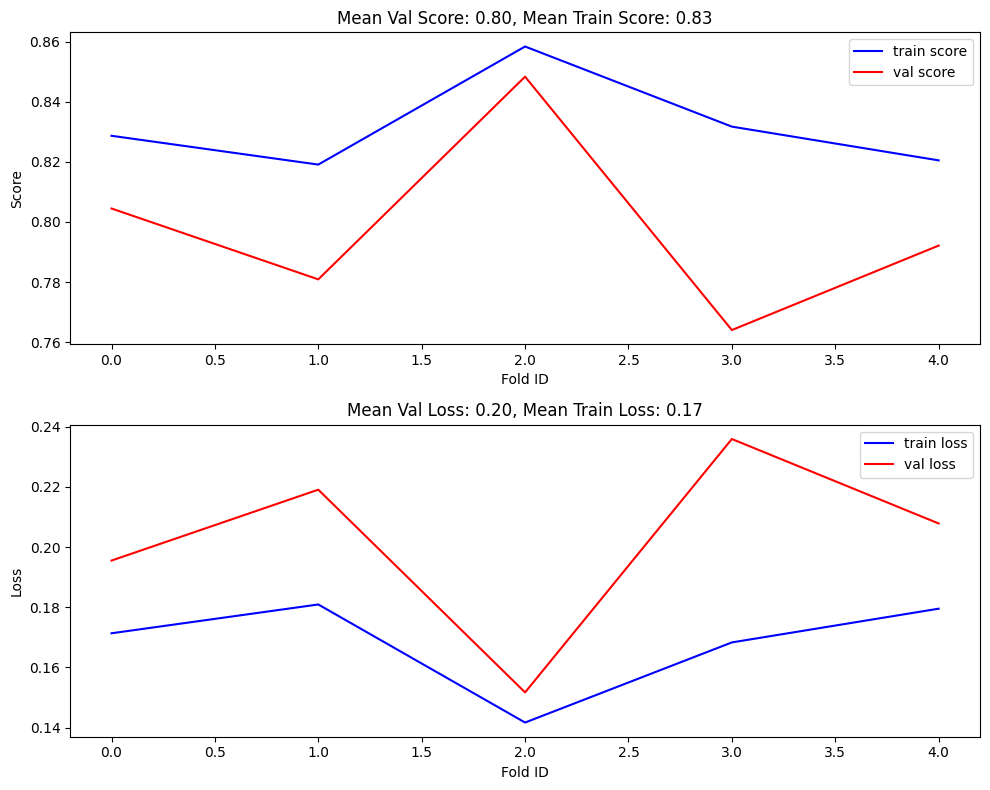

mean cv val score: 0.80
mean cv val loss 0.20
mean cv val score: 0.83
mean cv val loss 0.17


In [88]:
arr_X_normalized = np.asarray(X_train_enc)
hyper_parameters = {'n_neighbors': list(range(1, 20))}
gs_neigh_model = GridSearchCV(KNeighborsClassifier(n_neighbors=5), hyper_parameters).fit(arr_X_normalized, t)
print('Accuracy score for classification:')
print('gs_neigh_model', gs_neigh_model.best_score_)
print('best params', gs_neigh_model.best_params_)
estimate(X_train_enc, t, gs_neigh_model)

<div style="font-size:20px;">Let's try using LDA:</div>

Accuracy score for classification:
gs_model 0.8013495700207143
best params {'pca': PCA(n_components=12), 'pca__n_components': 12}


Computing Models:   0%|          | 0/5 [00:00<?, ?it/s]

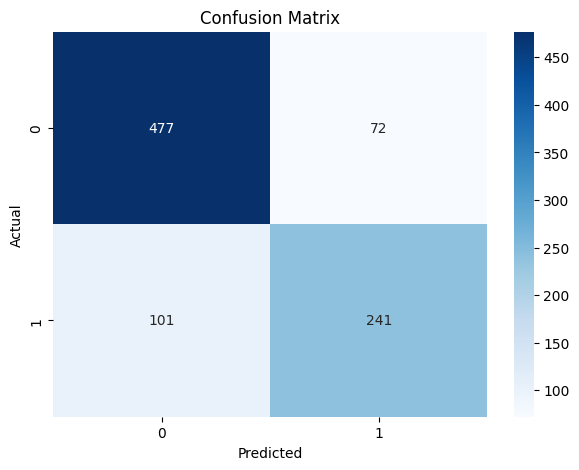

Precision: 0.77
Recall: 0.70
F1-score: 0.74
False Positive Rate (FPR): 0.13
Specificity: 0.87


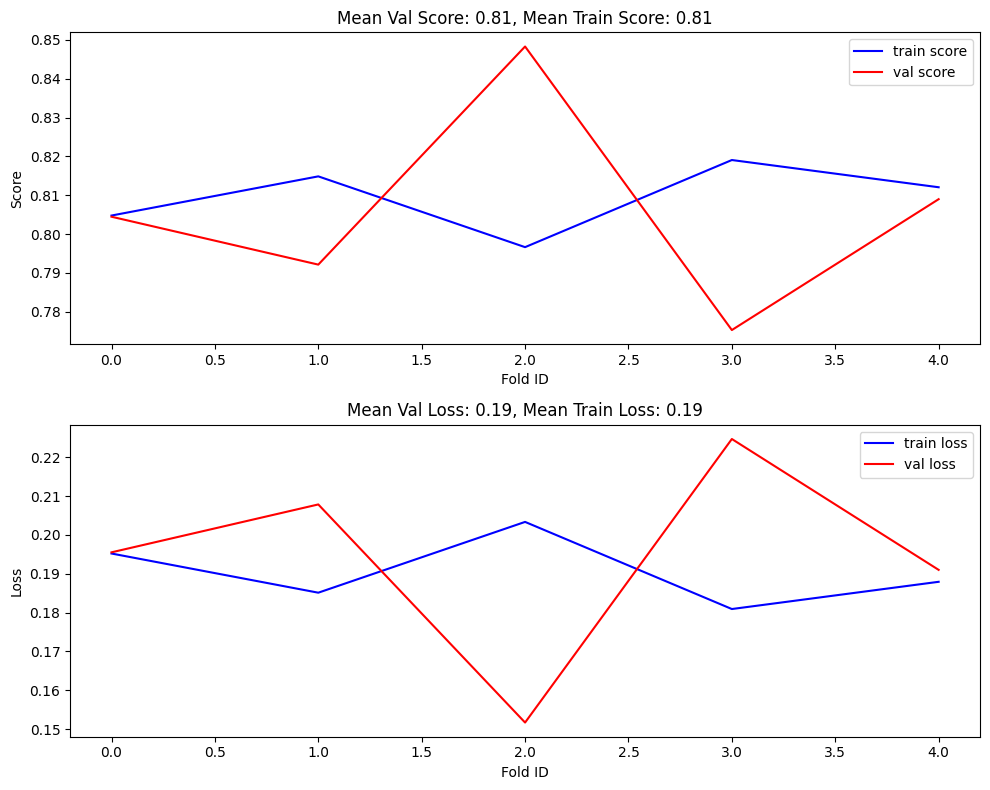

mean cv val score: 0.81
mean cv val loss 0.19
mean cv val score: 0.81
mean cv val loss 0.19


In [89]:
# use grid search to find best pca component on the data for lda
model_pipe = Pipeline([('pca', 'passthrough'),
                       ('lda', LinearDiscriminantAnalysis())])

hyper_parameters = {'pca': [PCA()],
                    'pca__n_components': list(range(1, len(X_train_enc.columns)-3))}

gs_model = GridSearchCV(model_pipe, hyper_parameters).fit(X_train_enc, t)
print('Accuracy score for classification:')
print('gs_model', gs_model.best_score_)
print('best params', gs_model.best_params_)
estimate(X_train_enc, t, gs_model)

<div style="font-size:20px;">We can see that the results are very similiar.</div>

<div style="font-size:20px;">After reviewing the results, we can deduce that the KNN provides the best results for our usecase. That makes sense, since KNN usually performs well on smaller datasets, and on categorical data which exists in this set.
<br> LDA performed good as well, but was slightly behind KNN in terms of results.
<br> NBC performed worse than the other two, probably since the data within the set doesn't satisfy the naive assumption this algorihm is based on.
<br> With that being said, we will continue our testing using the KNN model with k = 12.
</div>

<div style="font-size:30px;">
    Feature Selection:
</div>

<div style="font-size:20px;">
    We will be using the SequentialFeatureSelector to test forward feature selection:
</div>

Computing Models:   0%|          | 0/5 [00:00<?, ?it/s]

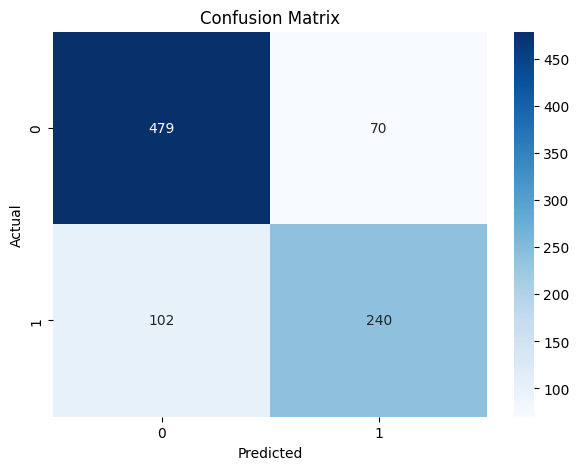

Precision: 0.77
Recall: 0.70
F1-score: 0.74
False Positive Rate (FPR): 0.13
Specificity: 0.87


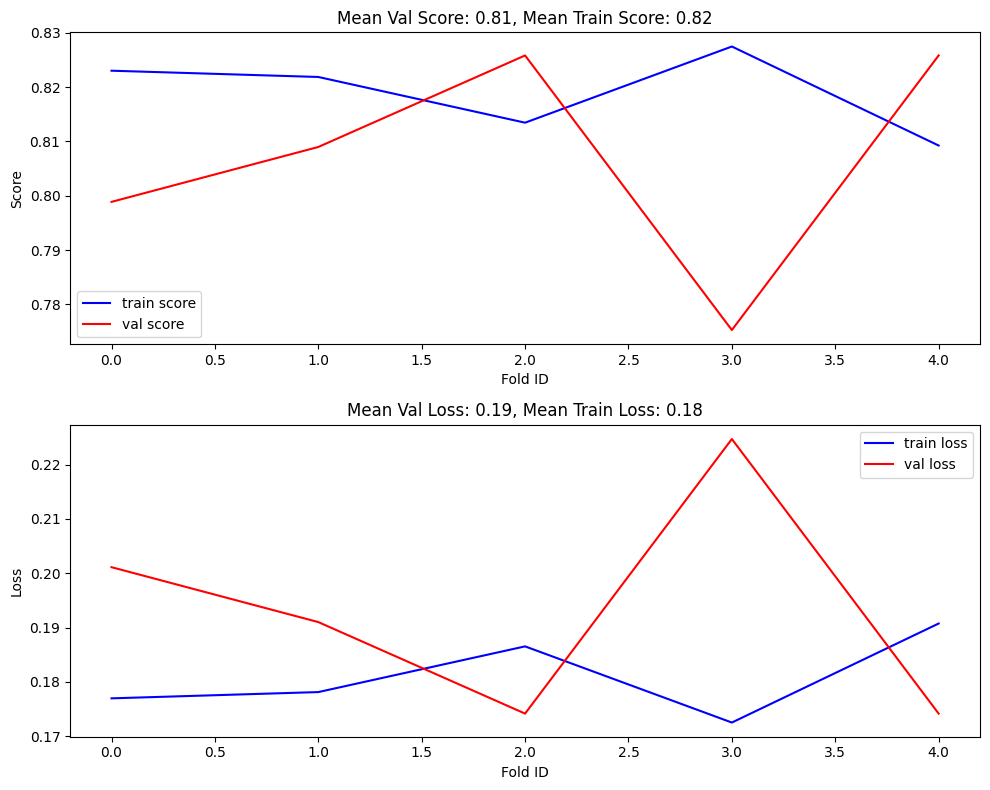

mean cv val score: 0.81
mean cv val loss 0.19
mean cv val score: 0.82
mean cv val loss 0.18


In [90]:
knn = KNeighborsClassifier(n_neighbors=12)
feature_selector = SequentialFeatureSelector(estimator=knn, n_features_to_select=5, direction='forward')
# Create a pipeline with feature selection and KNN
pipe = Pipeline([
('feature_selection', feature_selector),
('knn', knn)
])

# Fit the pipeline on the training data
pipe.fit(X_train_enc,t)

# # Get selected features (if needed)    
selected_features_mask = feature_selector.get_support()

X_forward_select = X_train_enc.loc[:,selected_features_mask]
estimate(X_forward_select, t, knn)

<div style="font-size:20px;">
    Next, we will use RFECV to test backward feature selection:
</div>

['Age' 'SibSp' 'Parch' 'AgePclass' 'Age+Pclass' 'FamilySize' 'isAlone'
 'FarePclass' 'Pclass_Age' 'Pclass_1' 'Pclass_2' 'Pclass_3' 'Sex_female'
 'Sex_male' 'Embarked_Q']


,Age,SibSp,Parch,AgePclass,Age+Pclass,FamilySize,isAlone,FarePclass,Pclass_Age,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_Q
0,0.271174,0.125,0.000000,0.294373,0.291856,0.1,0.0,0.042453,0.879840,0.0,0.0,1.0,0.0,1.0,0.0
1,0.472229,0.125,0.000000,0.167722,0.468892,0.1,0.0,0.139136,0.183879,1.0,0.0,0.0,1.0,0.0,0.0
2,0.321438,0.000,0.000000,0.348652,0.342438,0.0,1.0,0.046406,0.916942,0.0,0.0,1.0,1.0,0.0,0.0
3,0.434531,0.125,0.000000,0.154152,0.430956,0.1,0.0,0.103644,0.180877,1.0,0.0,0.0,1.0,0.0,0.0
4,0.434531,0.000,0.000000,0.470780,0.456247,0.0,1.0,0.047138,0.965213,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.334004,0.000,0.000000,0.240094,0.342438,0.0,1.0,0.050749,0.545846,0.0,1.0,0.0,0.0,1.0,0.0
887,0.233476,0.000,0.000000,0.081780,0.228629,0.0,1.0,0.058556,0.140154,1.0,0.0,0.0,1.0,0.0,0.0
888,0.367921,0.125,0.333333,0.398848,0.389215,0.3,0.0,0.137314,0.941589,0.0,0.0,1.0,1.0,0.0,0.0
889,0.321438,0.000,0.000000,0.113443,0.317147,0.0,1.0,0.058556,0.164787,1.0,0.0,0.0,0.0,1.0,0.0


Computing Models:   0%|          | 0/5 [00:00<?, ?it/s]

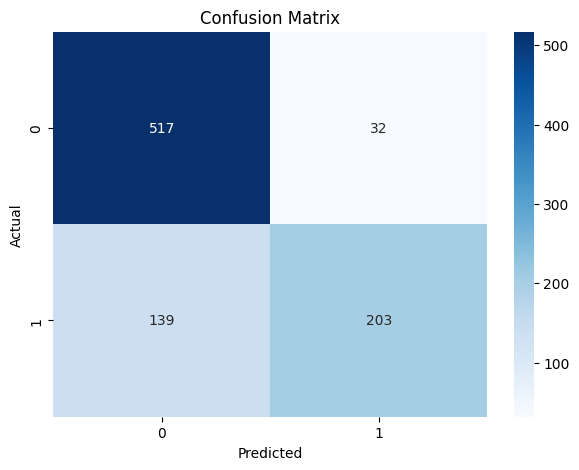

Precision: 0.86
Recall: 0.59
F1-score: 0.70
False Positive Rate (FPR): 0.06
Specificity: 0.94


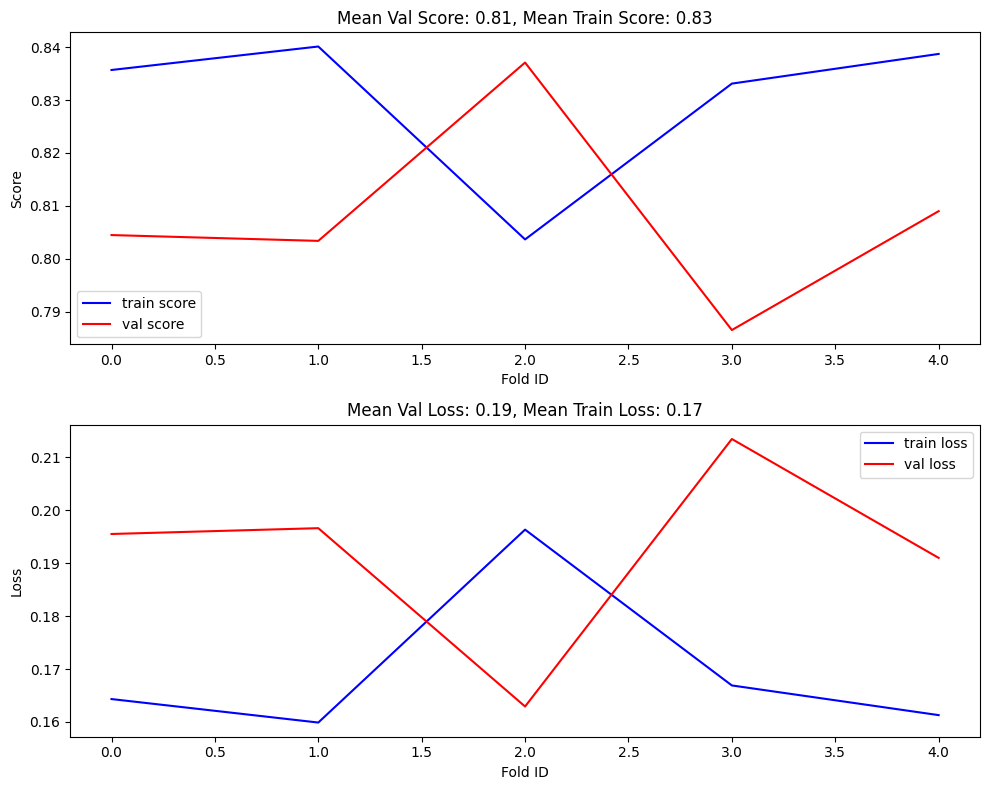

mean cv val score: 0.81
mean cv val loss 0.19
mean cv val score: 0.83
mean cv val loss 0.17


In [91]:
selector = RFECV(SGDClassifier(random_state=42),
                 cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)).fit(X_train_enc, t)
X_backward_selected_features= selector.get_feature_names_out()
print(X_backward_selected_features)
X_rfecv = X_train_enc.loc[:, selector.support_]
display(X_rfecv)
estimate(X_rfecv, t, knn)

<div style="font-size:20px;">Again, the results are very close, with a slight edge for the forward selection method. Thus we will use it.</div>

<div style="font-size:30px;">Grid Search VS Random Search</div>

<div style="font-size:20px;">We will check which search is better for our use case, for that we will use the SGD classifer.</div>

<div style="font-size:20px;">Grid Search:</div>

In [92]:
hyper_parameters = {
    'n_neighbors': list(range(1, 21)),  # Number of neighbors to consider
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Distance metric
}
gs_model = GridSearchCV(knn,hyper_parameters).fit(X_train_enc, t)
print('Accuracy score for classification:')
print('gs_model', gs_model.best_score_)
print('best params', gs_model.best_params_)

Accuracy score for classification:
gs_model 0.8103257799259305
best params {'metric': 'manhattan', 'n_neighbors': 8, 'weights': 'uniform'}


<div style="font-size:20px;">Random Search:</div>

In [93]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

np.random.seed(1)
distributions = dict(alpha=uniform(loc=0, scale=1), 
                     penalty=['l2', 'l1', 'elasticnet'])

rs_model = RandomizedSearchCV(knn,hyper_parameters).fit(X_train_enc, t)

print('Accuracy score for classification:')
print('rs_model', rs_model.best_score_)
print('best params', rs_model.best_params_)

Accuracy score for classification:
rs_model 0.8103257799259305
best params {'weights': 'uniform', 'n_neighbors': 8, 'metric': 'manhattan'}


<div style="font-size:20px;">Both Searches gave similiar accuracy results. Since it's a relatively small dataset, we will choose grid search.</div>

<div style="font-size:30px;">Ensembles</div>

<div style="font-size:20px;">After choosing the best model, features, and hyper parameters, we will try using ensembles in order to improve the accuracy of our model.
    <br> We will use the Bagging and Boosting methods.
</div>

 <div style="font-size:20px;">AdaBoosting:
</div>

Accuracy score for classification:
ada_boost_model 0.8552188552188552


Computing Models:   0%|          | 0/5 [00:00<?, ?it/s]

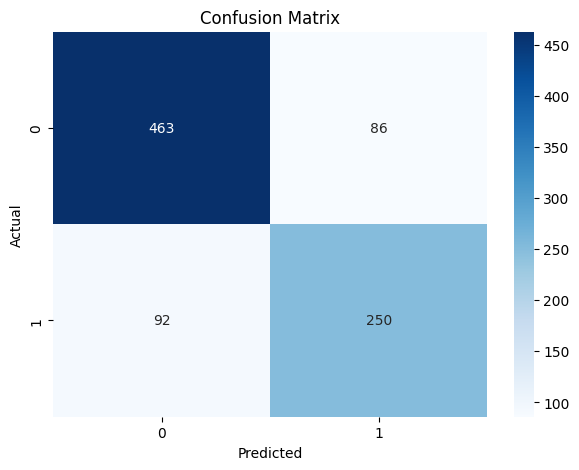

Precision: 0.74
Recall: 0.73
F1-score: 0.74
False Positive Rate (FPR): 0.16
Specificity: 0.84


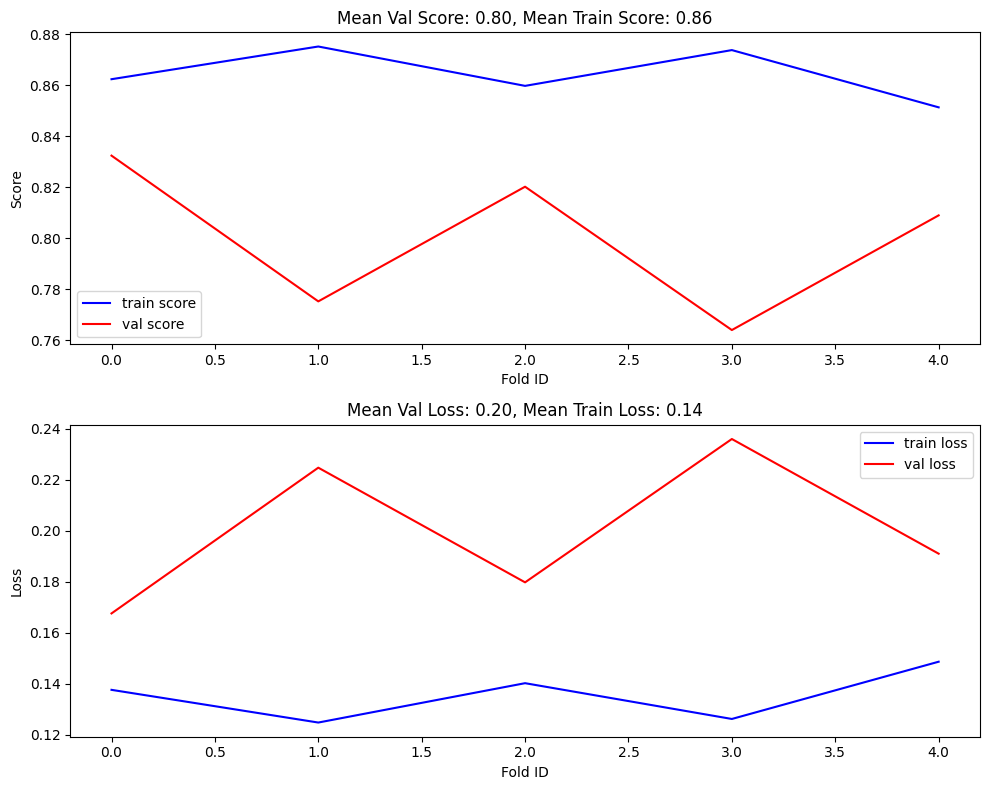

mean cv val score: 0.80
mean cv val loss 0.20
mean cv val score: 0.86
mean cv val loss 0.14


In [104]:
# get score with ada boosting
from sklearn.ensemble import AdaBoostClassifier

ada_boost_model = AdaBoostClassifier(n_estimators=100, random_state=42).fit(X_train_enc, t)

print('Accuracy score for classification:')
print('ada_boost_model', ada_boost_model.score(X_train_enc, t).mean())
estimate(X_train_enc, t, ada_boost_model)

<div style="font-size:20px;">Nfold Bagging:
</div>

Accuracy score for classification:
bag_fold_model 0.8316498316498316


Computing Models:   0%|          | 0/5 [00:00<?, ?it/s]

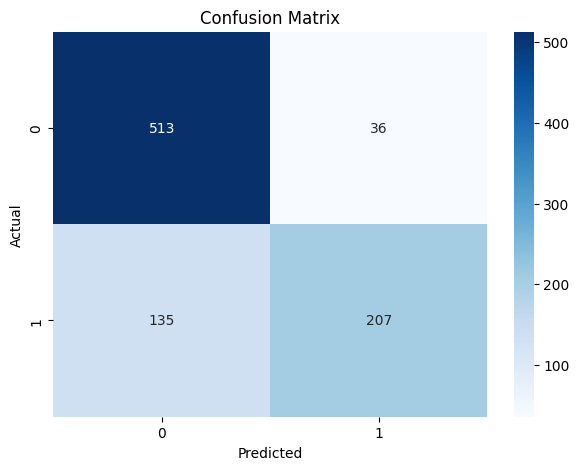

Precision: 0.85
Recall: 0.61
F1-score: 0.71
False Positive Rate (FPR): 0.07
Specificity: 0.93


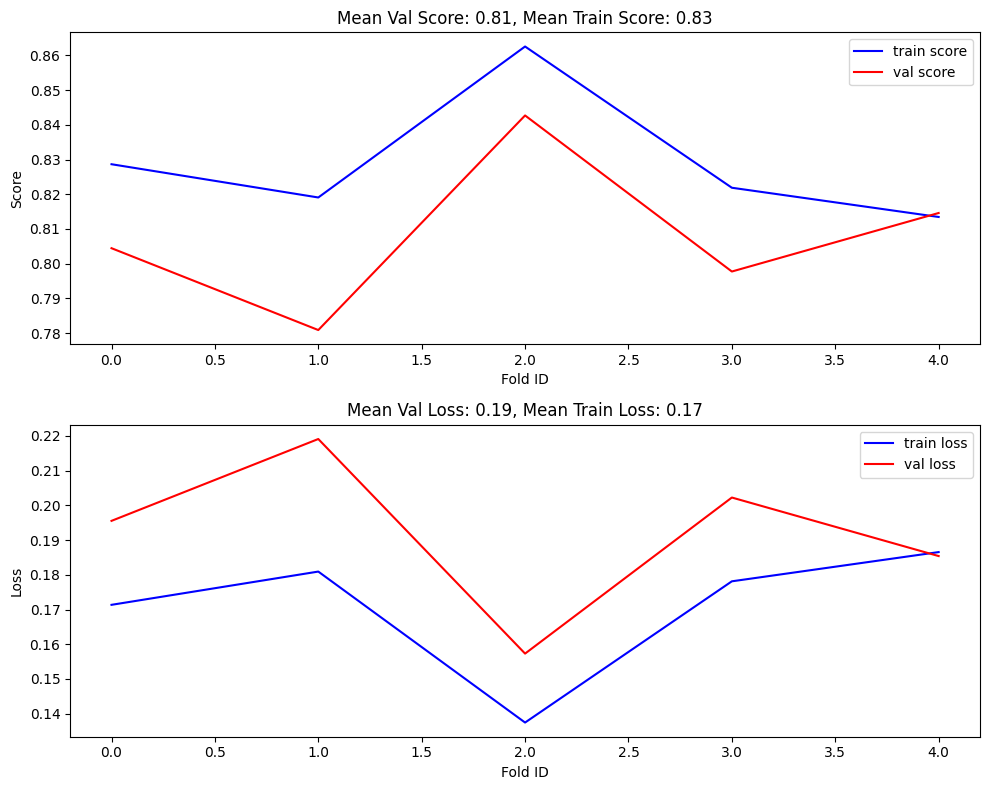

mean cv val score: 0.81
mean cv val loss 0.19
mean cv val score: 0.83
mean cv val loss 0.17


In [102]:
# get score with nfold bagging
from sklearn.ensemble import BaggingClassifier

bag_fold_model = BaggingClassifier(base_estimator=gs_model,
                                   n_estimators=20, random_state=42,
                                   bootstrap=False).fit(X_train_enc, t)

print('Accuracy score for classification:')
print('bag_fold_model', bag_fold_model.score(X_train_enc, t).mean())
estimate(X_train_enc, t, bag_fold_model)

 <div style="font-size:20px;">Bootstrap Bagging:
</div>

Accuracy score for classification:
bag_boot_model 0.978675645342312


Computing Models:   0%|          | 0/5 [00:00<?, ?it/s]

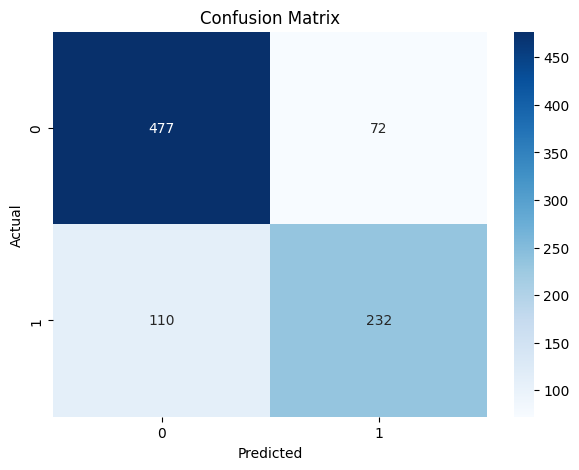

Precision: 0.76
Recall: 0.68
F1-score: 0.72
False Positive Rate (FPR): 0.13
Specificity: 0.87


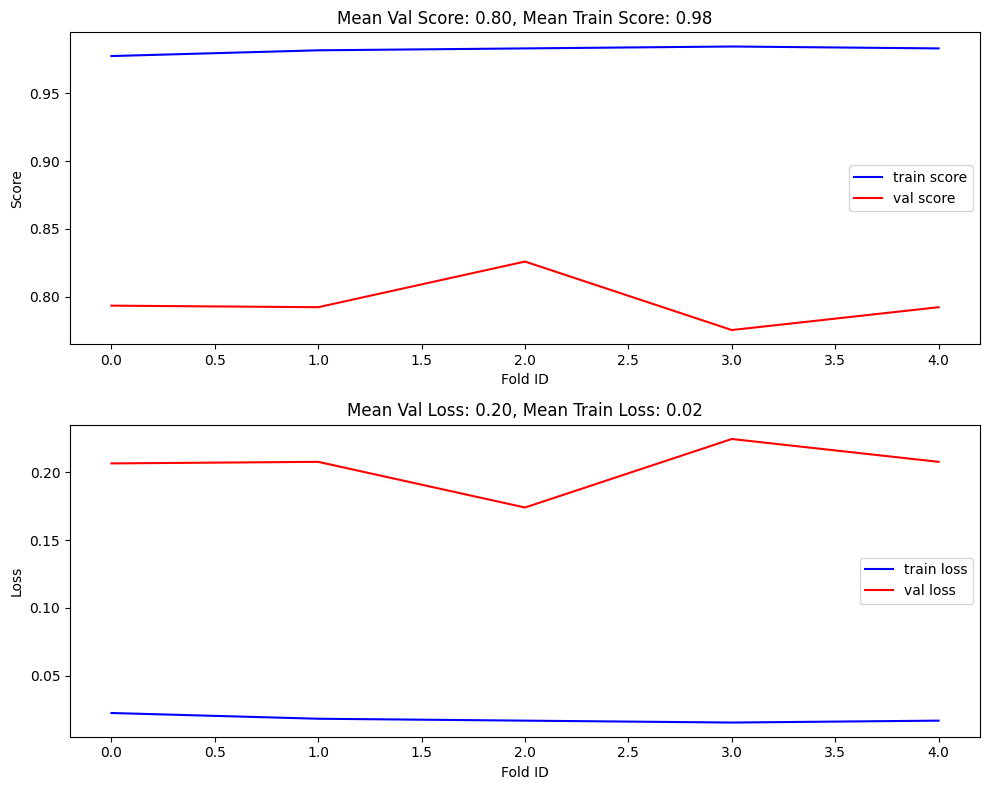

mean cv val score: 0.80
mean cv val loss 0.20
mean cv val score: 0.98
mean cv val loss 0.02


In [103]:
# get score with bootstrap bagging
bag_boot_model = BaggingClassifier(base_estimator=gs_model,
                                   n_estimators=20, random_state=42,
                                   bootstrap=True).fit(X_train_enc, t)

print('Accuracy score for classification:')
print('bag_boot_model', bag_boot_model.score(X_train_enc, t).mean())
estimate(X_train_enc, t, bag_boot_model)

<div style="font-size:20px;">Bootstrap bagging got the best score by a significant margin, so we will use it for the submission</div>

<div style="font-size:20px;">
    Let's analyze the results presented in the confusion matrix and the plot of the bootstrap bagging algorithm:
    <br> Since this model predicts something that cannot be changed, and happened many years ago, we believe the most important KPI for this problem is the accuracy. Therefore, we want to pick the model with the largest value for the sum of the main diagonal of the confusion matrix.
    <br> As for the plot of score and loss, the results don't vary much between various folds.
    <br> As for the KPIs:
    <br>
    <br> Precision (0.76): 76% of the people predicted to survive actually survived. This presents that model is good at predicting the positive class with few incorrect positive predictions.
    <br>
    <br> Recall (0.68): 68% of the actual survivors were correctly identified by the model. This indicates that the model misses some positive cases. There are false negatives where actual positive cases are predicted as negative.
    <br> F1-score (0.72): The model has a good balance between correctly identifying survivors and not incorrectly predicting too many non-survivors as survivors.
    <br>
    <br> FPR (0.13):The model is fairly good at not predicting negative cases as positive, though there's a small rate of false positives.
    <br>
    <br>Specificity (0.87): Indicates the model is good at correctly identifying negative cases.
</div>

<div style="font-size:30px;">Submission</div>

In [97]:
#bagging bootstrap
submission_boot = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')
submission_forward_boot['Survived'] = bag_boot_model.predict(test_enc)
submission_forward_boot.to_csv('boot.csv', index=False)


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


<div style="font-size:20px;">Screenshots of our last 10 submissions and Position on the leaderboard:</div>

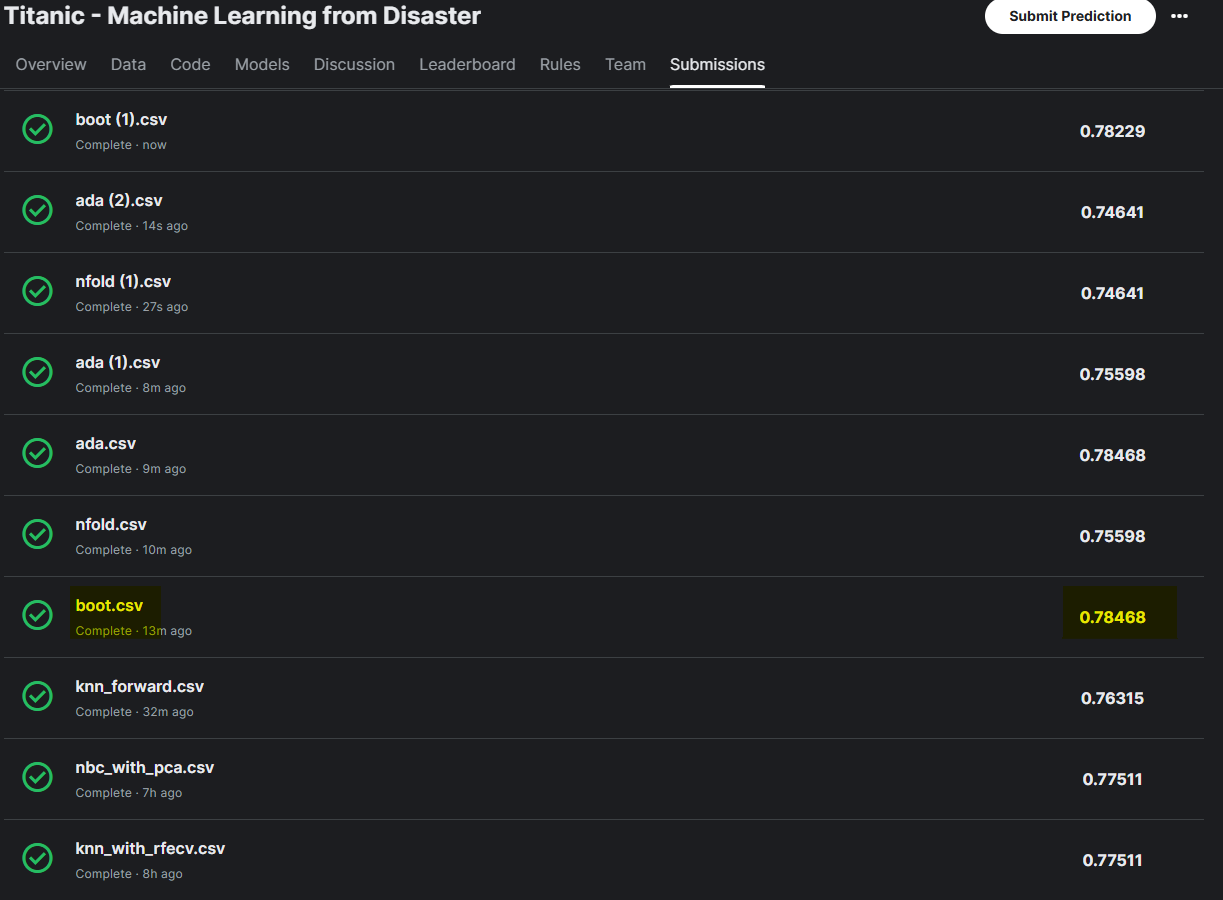

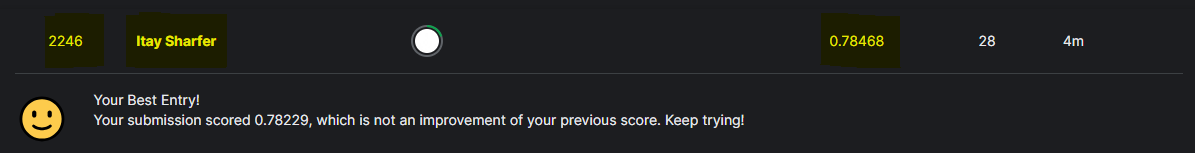

<div style="font-size:30px;"> Summary:
</div>

<div style="font-size:20px;">
We tried different methods in order to increase our score. We tried sending submissions using the different models with both forward and backward feature selection. These did improve our score, but not by a lot.
<br> Afterwards, we used gridsearch in order to fine-tune the hyper parameters and used ensembles to further increase the accuracy of our model. Those changes improved our model accuracy significantly.
</div>



<div style="font-size:30px;"> References:
</div>

<div style="font-size:20px;">
    Data analysis:
<br>1. <a href="https://www.kaggle.com/code/abhishekchhibber/predicting-titanic-survival-using-knn">Kaggle notebook</a>
<br>2. <a href="https://www.kaggle.com/code/faressayah/ensemble-ml-algorithms-bagging-boosting-voting">Kaggle notebook</a>
<br>Video walkthrough:
<br>3 .<a href="https://www.youtube.com/watch?v=tjy0yL1rRRU&ab_channel=DataMListic">video</a>
<br> Python functions and library functions were taken from the notebooks provided by the course.
</div>